In [1]:
# IMPORTS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import math 
import scipy

from matplotlib.dates import DateFormatter
from scipy.optimize import curve_fit
from sklearn.metrics import mean_absolute_error
from glob import glob
from os import path
from collections import defaultdict
from skspatial.objects import Plane
from skspatial.objects import Points
from skspatial.plotting import plot_3d
from virocon import (
    GlobalHierarchicalModel,
    ExponentiatedWeibullDistribution,
    WeibullDistribution,
    DependenceFunction,
    WidthOfIntervalSlicer,
    plot_marginal_quantiles,
    plot_dependence_functions,
    _fitting
)

from virocon._fitting import (
    fit_function,
    fit_constrained_function,
    convert_bounds_for_curve_fit,
)

import sys
sys.path.insert(0, path.abspath(path.join(path.curdir, '../src')))

%matplotlib notebook

# Data

In [248]:
# Read data

data = pd.read_csv('/Volumes/MASTERTHESE/MasterThese/data_unsorted.csv')
data= data.drop(columns=['Unnamed: 0'])
data= data.rename(columns={"peakDeflection": "peakDeflectionSBIT"})
print(data)

      windSpeed  waveHeight  waveTp  waveTz  peakDeflectionSBIT  \
0      4.064444        1.39    7.14   5.263              2.7032   
1      3.959574        1.39    7.14   5.263              2.7870   
2      3.863043        1.39    7.14   5.263              3.6654   
3      3.744186        1.39    7.14   5.263              3.7484   
4      3.872340        1.39    7.14   5.263              4.8689   
...         ...         ...     ...     ...                 ...   
1267   3.991071        0.43    5.88   3.030              4.7862   
1268   4.268966        0.43    5.88   3.030              2.1788   
1269   3.841071        0.43    5.88   3.030              3.7424   
1270   4.678333        0.43    5.88   3.030              1.4381   
1271   4.188136        0.43    5.88   3.030              1.6619   

      peakDeflectionTower  
0                 15.6301  
1                 17.3423  
2                 14.7588  
3                 22.1884  
4                 15.9363  
...                   ...  

<ipython-input-249-6b148dda4904>:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


<IPython.core.display.Javascript object>


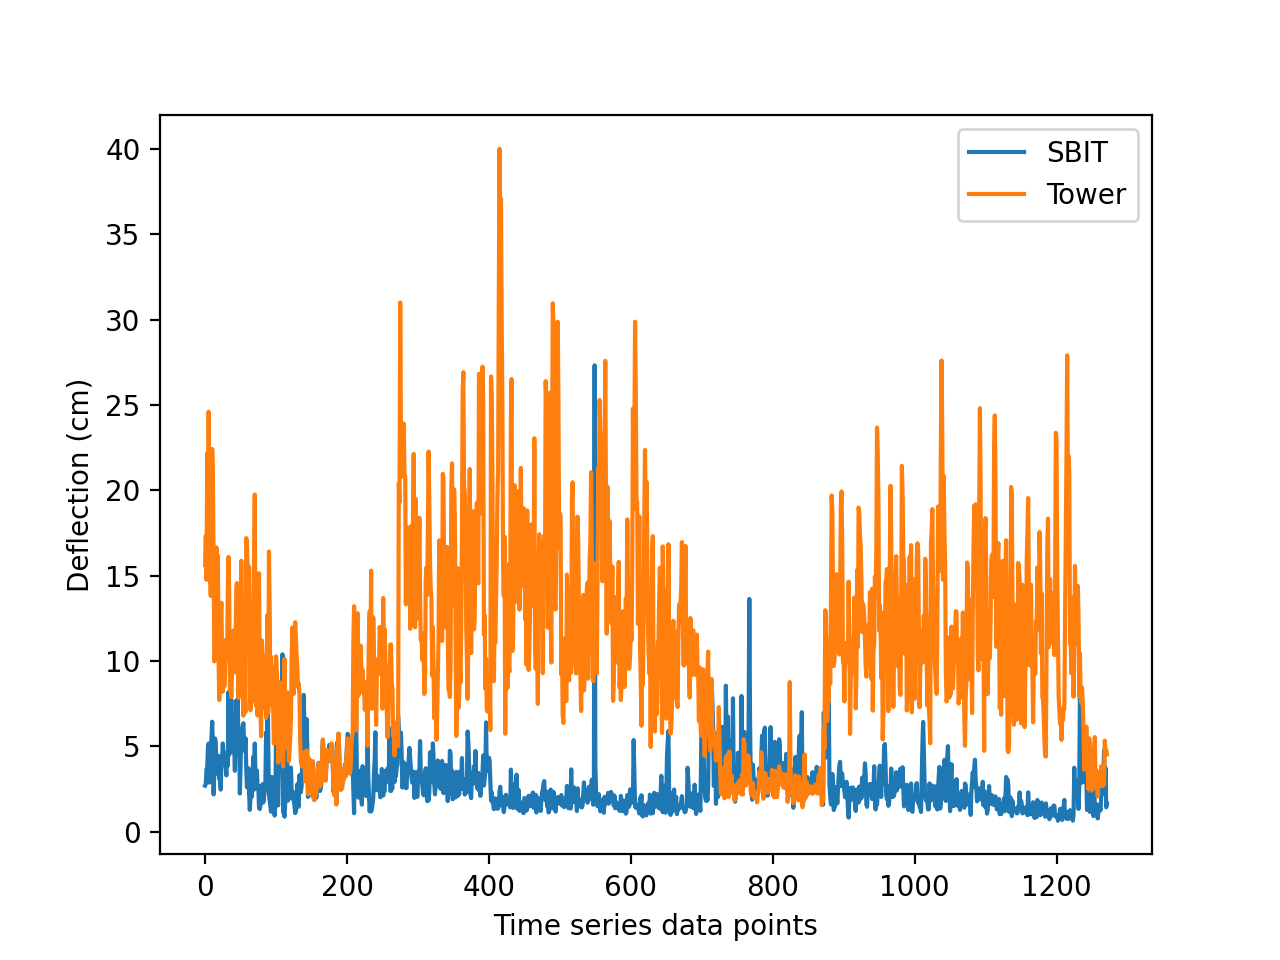

In [249]:
plt.figure()
plt.plot(data.peakDeflectionSBIT, label='SBIT')
plt.plot(data.peakDeflectionTower, label='Tower')
plt.xlabel('Time series data points')
plt.ylabel('Deflection (cm)')
plt.legend()

In [250]:
data = data.drop(data[(data.peakDeflectionTower- data.peakDeflectionSBIT) < 5].index)
data = data[data['windSpeed'].notna()]
data= data.reset_index(drop=True)
print(data)

     windSpeed  waveHeight  waveTp  waveTz  peakDeflectionSBIT  \
0     4.064444        1.39    7.14   5.263              2.7032   
1     3.959574        1.39    7.14   5.263              2.7870   
2     3.863043        1.39    7.14   5.263              3.6654   
3     3.744186        1.39    7.14   5.263              3.7484   
4     3.872340        1.39    7.14   5.263              4.8689   
..         ...         ...     ...     ...                 ...   
795   3.237931        0.54    4.35   3.361              2.8250   
796   3.827119        0.54    4.35   3.361              2.9406   
797   3.351724        0.54    4.35   3.361              1.3385   
798   3.532203        0.54    4.35   3.361              2.5891   
799   4.589655        0.54    4.35   3.361              2.8813   

     peakDeflectionTower  
0                15.6301  
1                17.3423  
2                14.7588  
3                22.1884  
4                15.9363  
..                   ...  
795              1

<ipython-input-251-d85882b8c094>:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


<IPython.core.display.Javascript object>


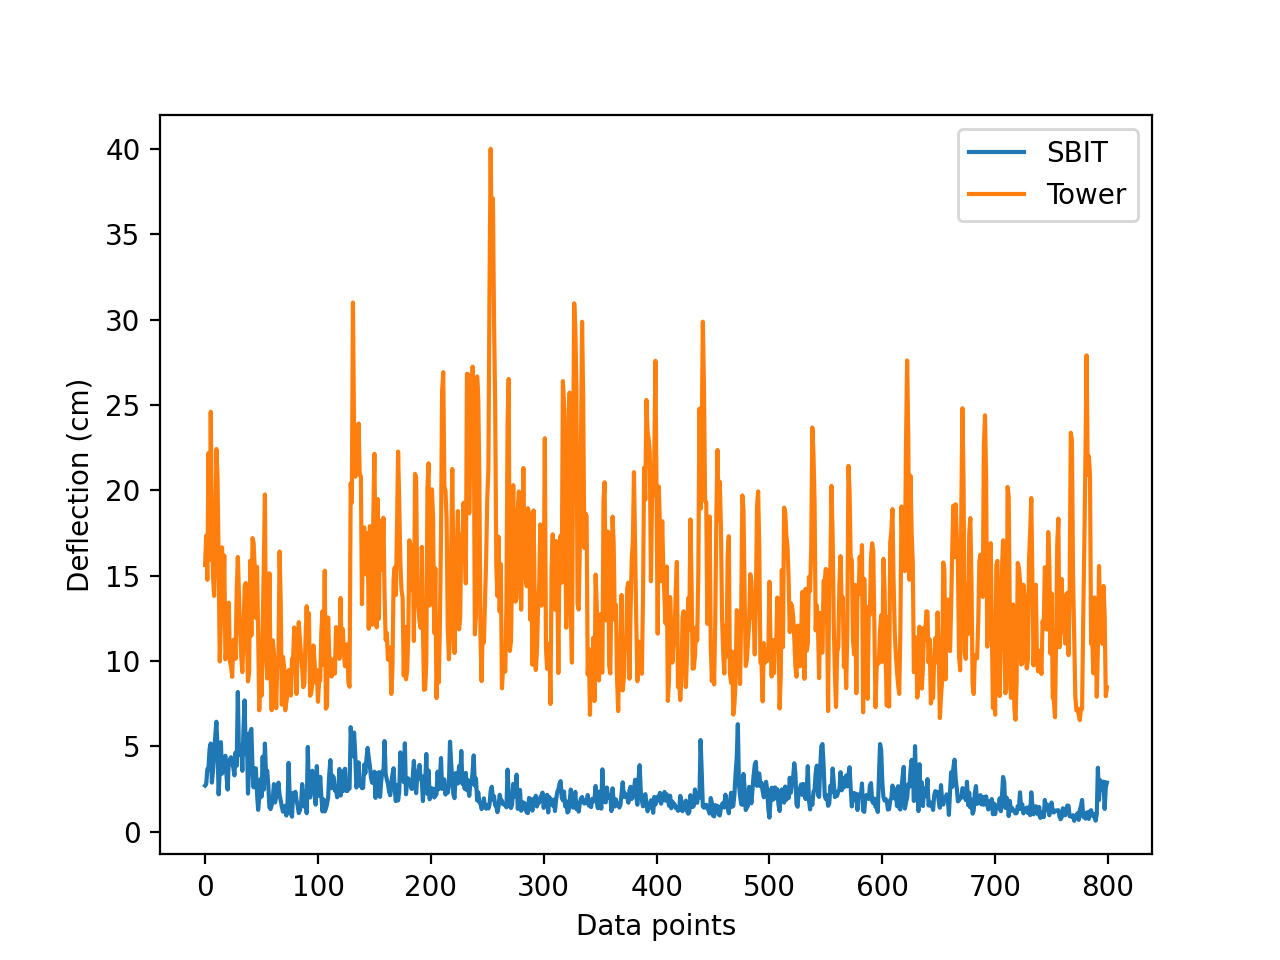

In [251]:
plt.figure()
plt.plot(data.peakDeflectionSBIT, label='SBIT')
plt.plot(data.peakDeflectionTower, label='Tower')
plt.xlabel('Data points')
plt.ylabel('Deflection (cm)')
plt.legend()

# Histogram

In [129]:
# set up the histogramm, 60 steps= bin size of 0,5 cm deflection
bins = np.linspace(0, 40, 80)
bin_centers = 0.5*(bins[1:] + bins[:-1])

# fit GEV and weibull distribution to data
gev_fit_tower= stats.genextreme.fit(data.peakDeflectionTower)
gev_pdf_tower= stats.genextreme.pdf(bin_centers, gev_fit_tower[0], loc= gev_fit_tower[1], scale= gev_fit_tower[2])
gev_ppf_tower= stats.genextreme.ppf(bin_centers, gev_fit_tower[0], loc= gev_fit_tower[1], scale= gev_fit_tower[2])
gev_cdf_tower= stats.genextreme.cdf(bin_centers, gev_fit_tower[0], loc= gev_fit_tower[1], scale= gev_fit_tower[2])

#weib_fit = stats.weibull_min.fit(data.deflection)
#weib_cdf= stats.weibull_min.cdf(bin_centers, weib_fit[0], loc= weib_fit[1], scale= weib_fit[2])

#print(weib_fit)
print(gev_fit_tower)

(-0.1118007401397142, 11.45977029288046, 3.496913938662952)


<IPython.core.display.Javascript object>


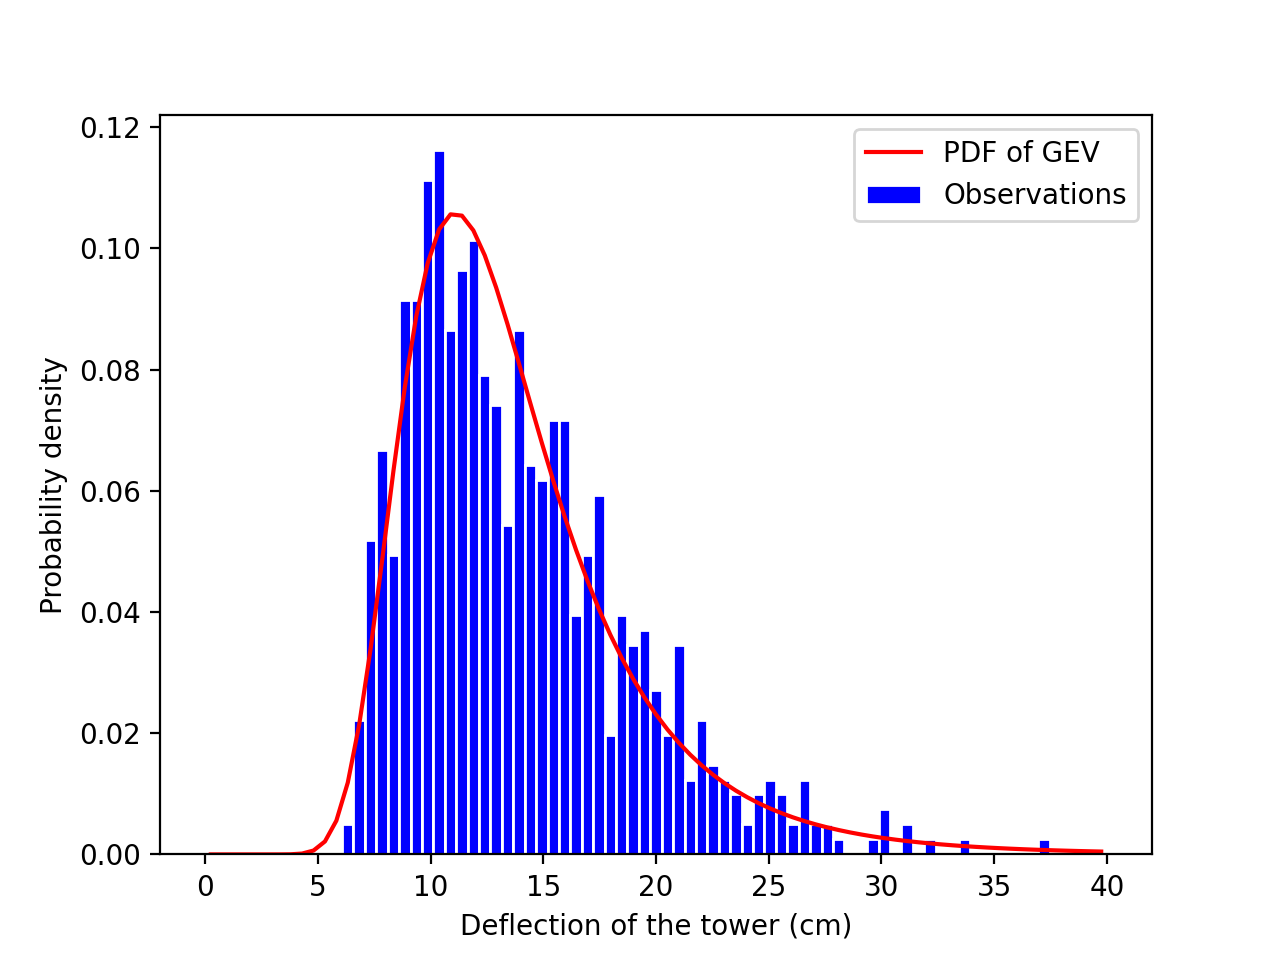

In [130]:
fig, ax1 = plt.subplots()

ax1.hist(data.peakDeflectionTower, bins=bins, label='Observations', color='b', density= 'true', stacked='true', edgecolor='w')
ax1.plot(bin_centers, gev_pdf_tower, label="PDF of GEV", color='r')
ax1.set_xlabel('Deflection of the tower (cm)')
ax1.set_ylabel('Probability density')

ax1.legend()

plt.show()

<IPython.core.display.Javascript object>


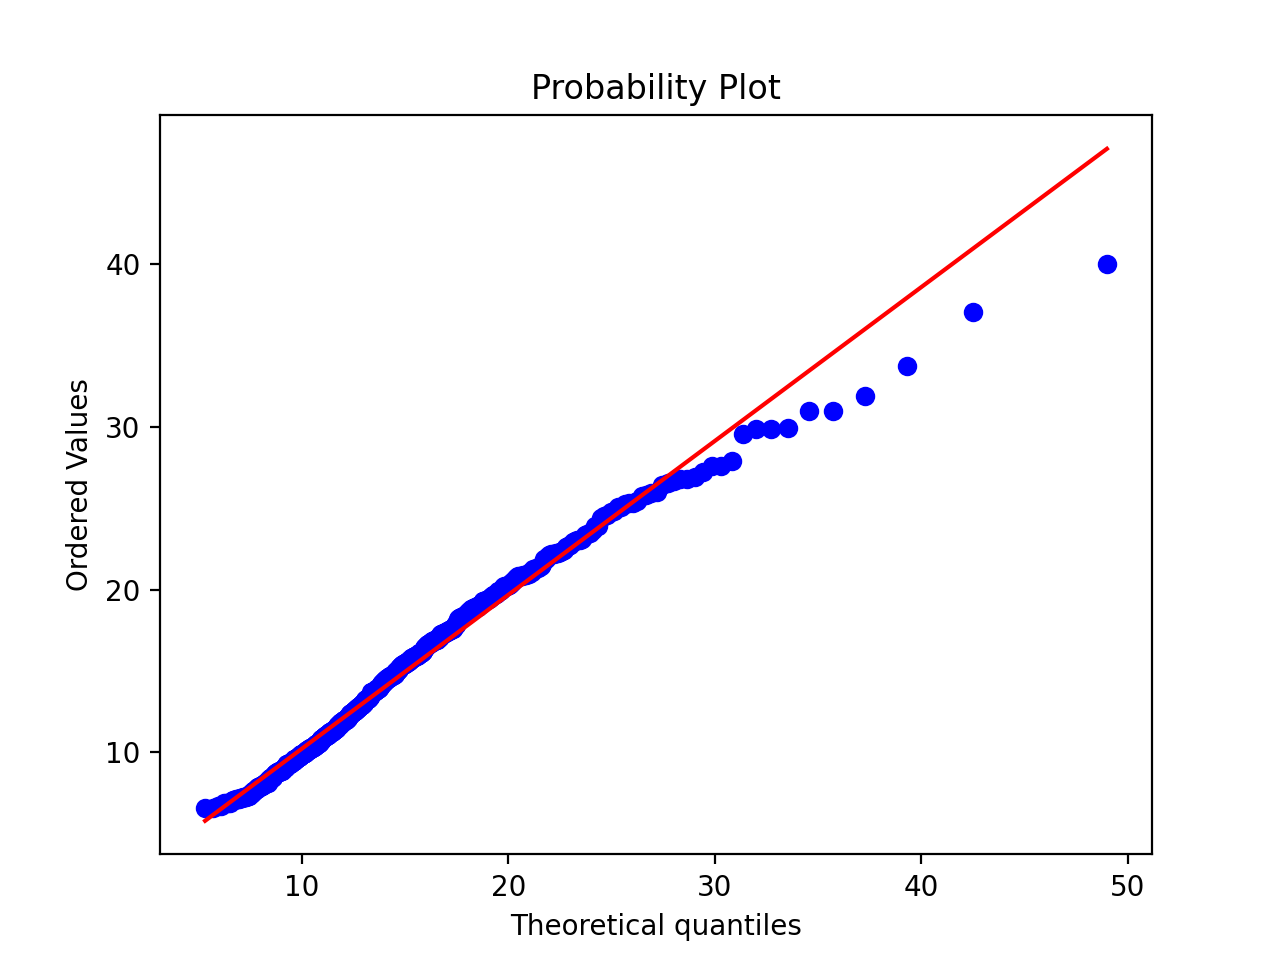

In [131]:
fig = plt.figure()
ax = fig.add_subplot(111)
stats.probplot(data.peakDeflectionTower, (gev_fit_tower[0], gev_fit_tower[1], gev_fit_tower[2]), dist='genextreme', plot=ax)
#ax.set_title("Probability plot of sample data against the quantiles of a specified theoretical distribution.")
plt.show()

# Scatter Plots

<IPython.core.display.Javascript object>


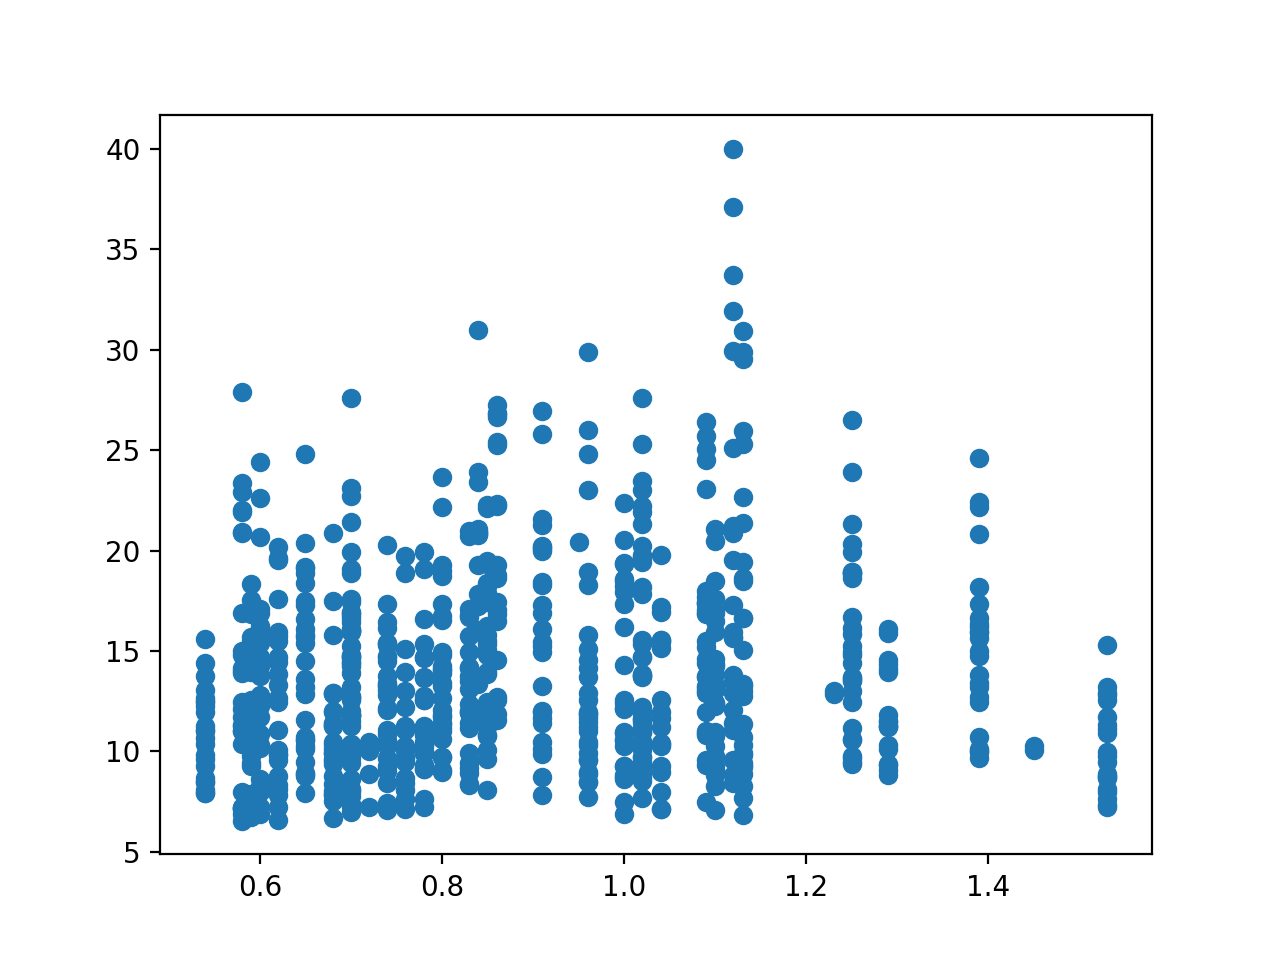

In [132]:
plt.figure()
plt.scatter(data.waveHeight, data.peakDeflectionTower)

<IPython.core.display.Javascript object>


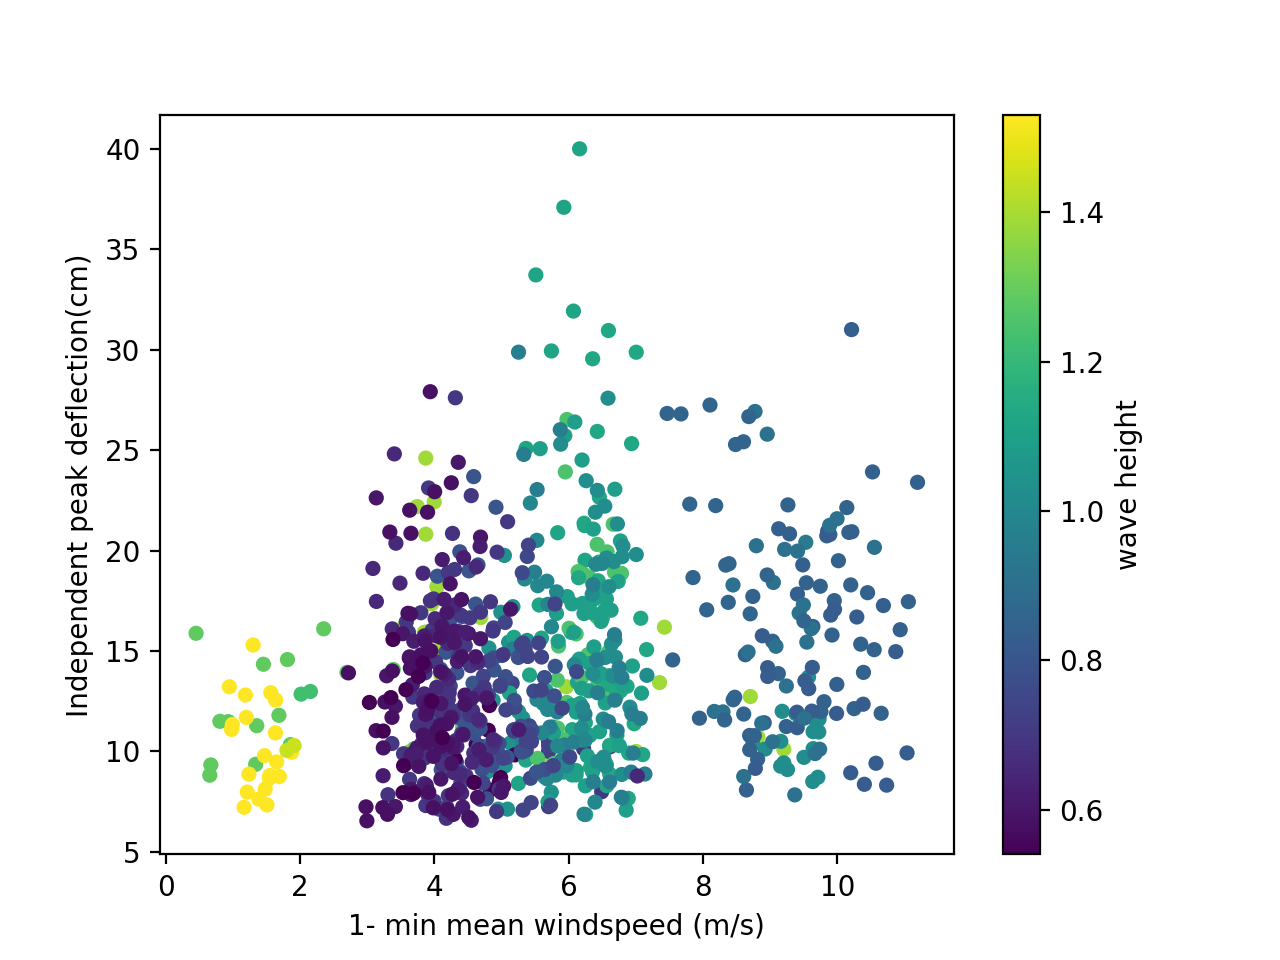

In [135]:
fig, ax1 = plt.subplots(1)
scatter= ax1.scatter(data.windSpeed, data.peakDeflectionTower, s=20, c=data.waveHeight)
ax1.set_xlabel('1- min mean windspeed (m/s)')
ax1.set_ylabel('Independent peak deflection(cm)')
fig.colorbar(scatter,label='wave height')

<IPython.core.display.Javascript object>


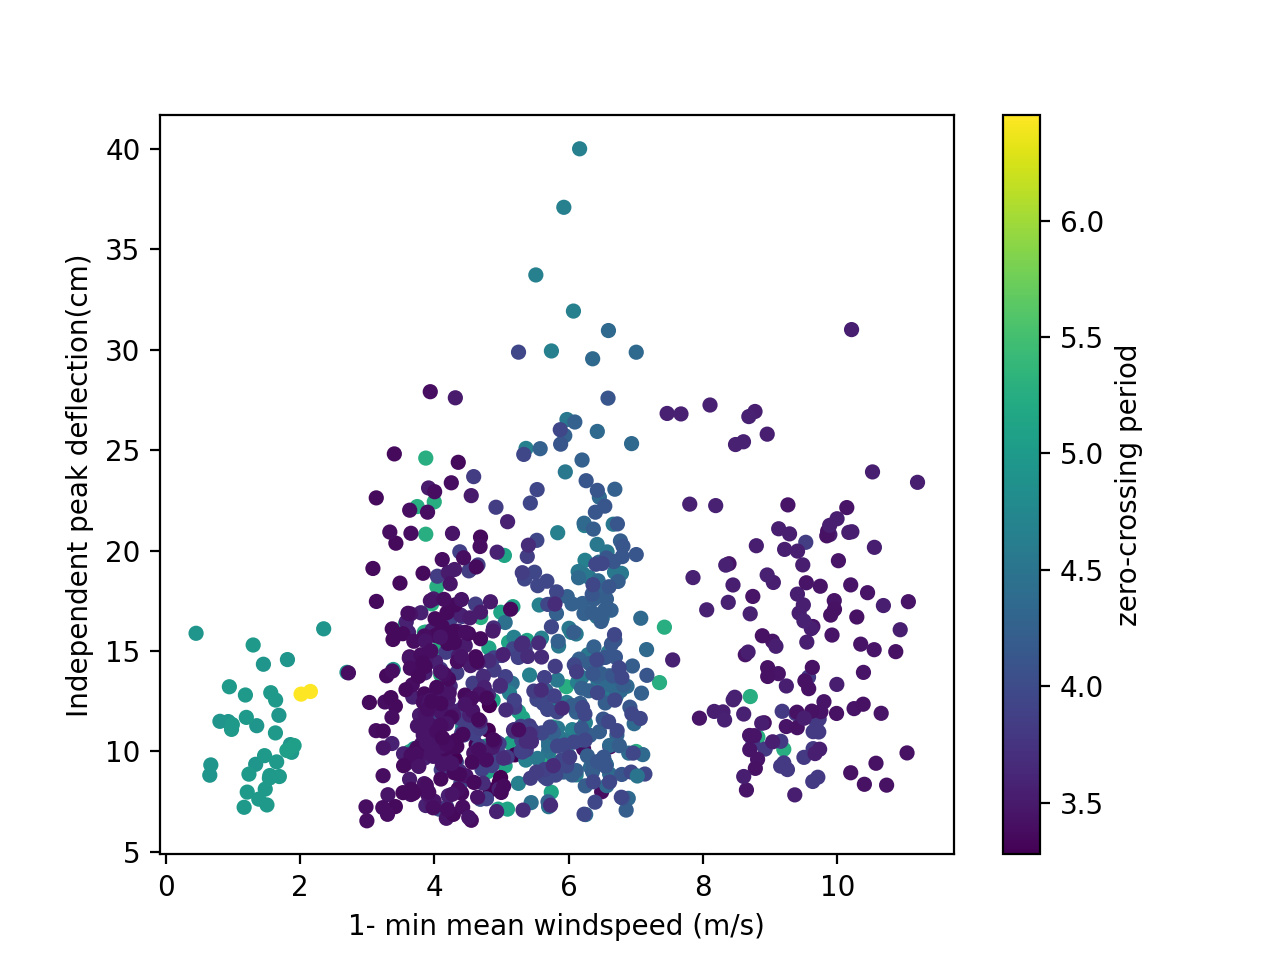

In [134]:
fig, ax1 = plt.subplots(1)
scatter= ax1.scatter(data.windSpeed, data.peakDeflectionTower, s=20, c=data.waveTz)
ax1.set_xlabel('1- min mean windspeed (m/s)')
ax1.set_ylabel('Independent peak deflection(cm)')
fig.colorbar(scatter,label='zero-crossing period')

<IPython.core.display.Javascript object>


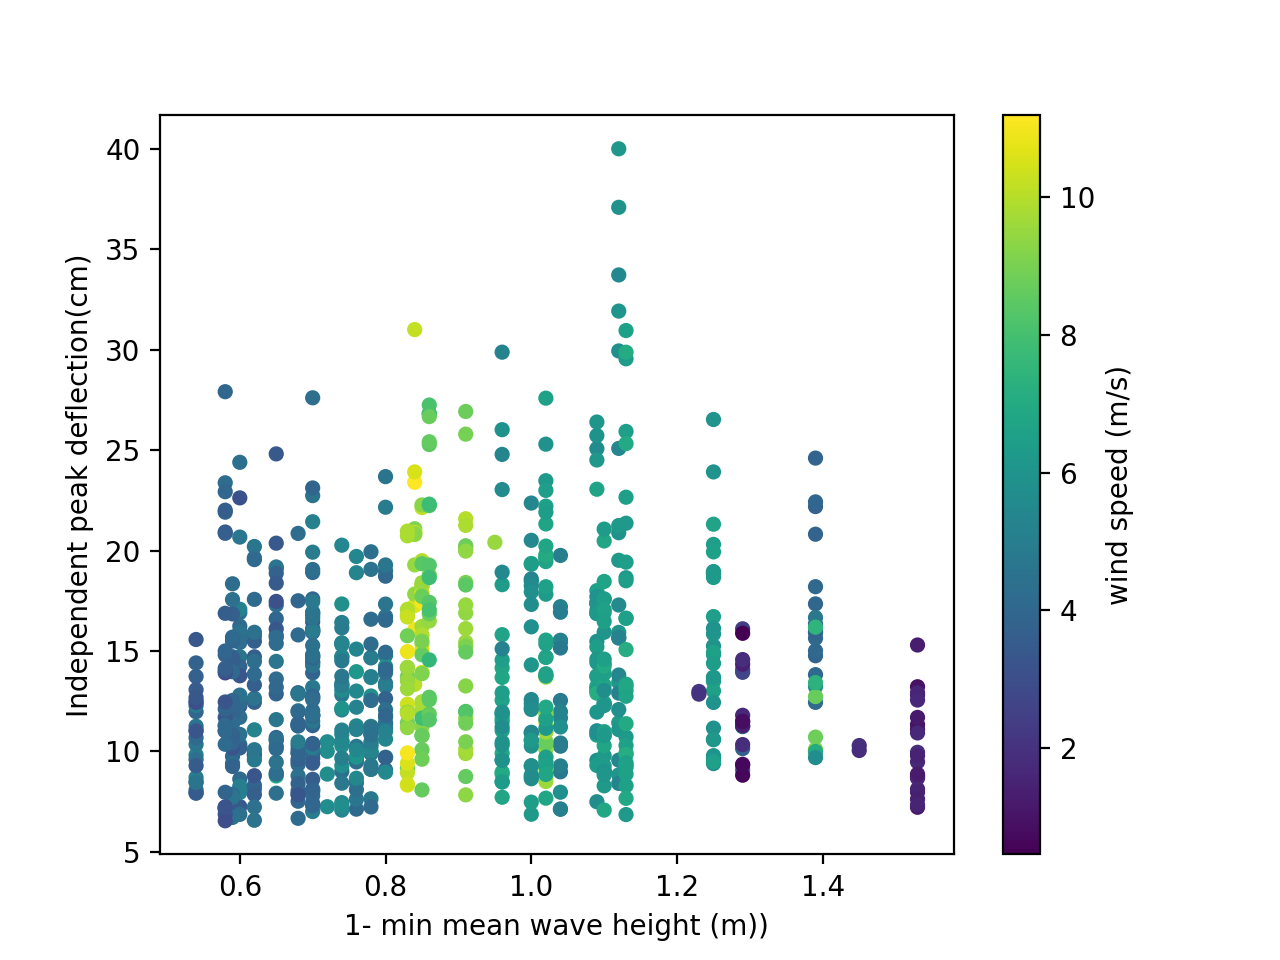

In [136]:
fig, ax1 = plt.subplots(1)
scatter= ax1.scatter(data.waveHeight, data.peakDeflectionTower, s=20, c=data.windSpeed)
ax1.set_xlabel('1- min mean wave height (m))')
ax1.set_ylabel('Independent peak deflection(cm)')
fig.colorbar(scatter,label='wind speed (m/s)')

<IPython.core.display.Javascript object>


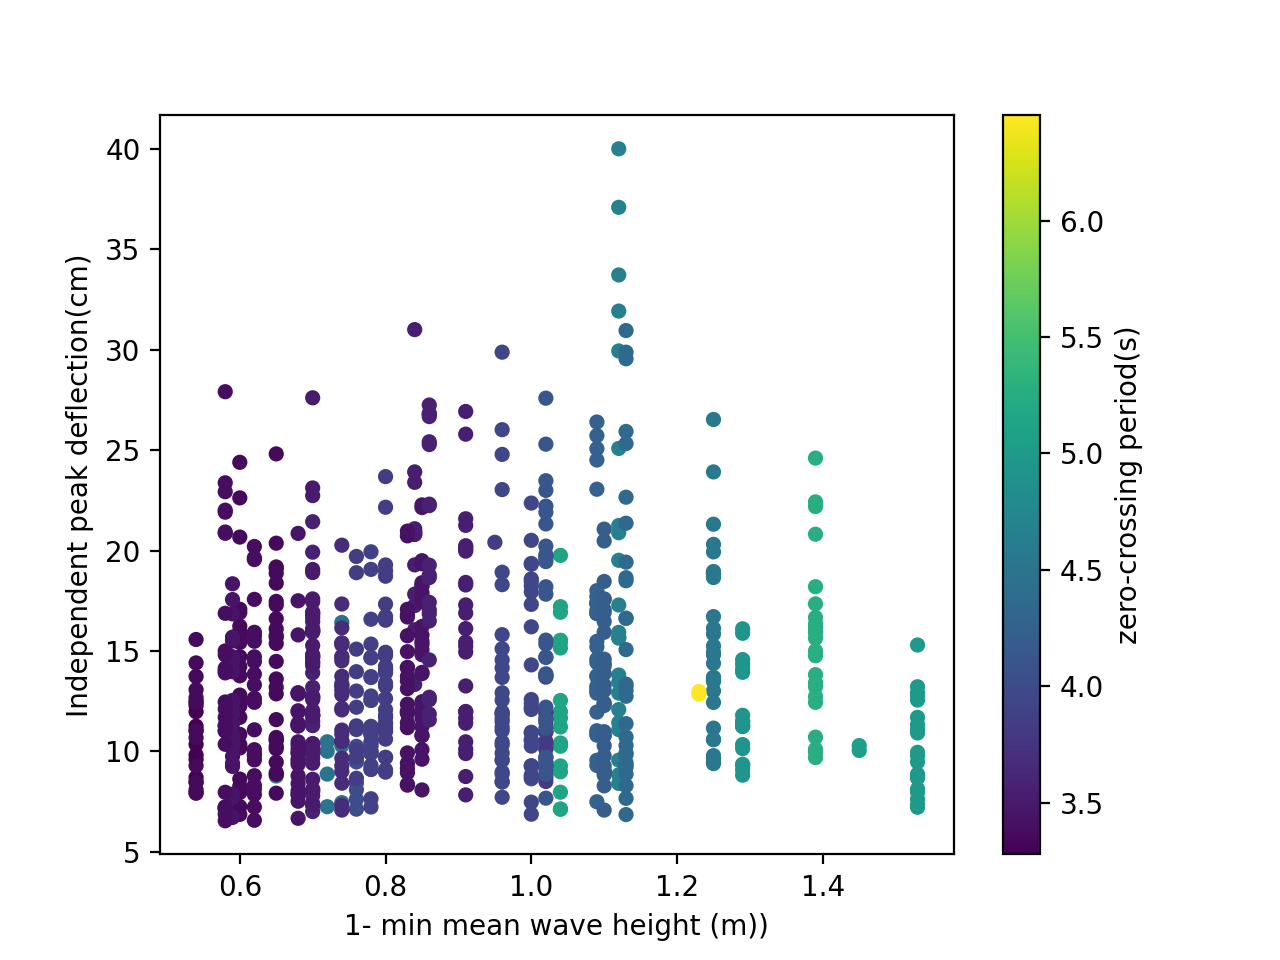

In [137]:
fig, ax1 = plt.subplots(1)
scatter= ax1.scatter(data.waveHeight, data.peakDeflectionTower, s=20, c=data.waveTz)
ax1.set_xlabel('1- min mean wave height (m))')
ax1.set_ylabel('Independent peak deflection(cm)')
fig.colorbar(scatter,label='zero-crossing period(s)')

# Interval Slicer

In [138]:
width_slicer_V = WidthOfIntervalSlicer(width=1, reference="center", min_n_points=1)
width_slicer_Hs = WidthOfIntervalSlicer(width=0.125, reference="center", min_n_points=1)
#width_slicer_Tz = WidthOfIntervalSlicer(width=0.5, reference="right", min_n_points=1)

wind_slices, wind_references, wind_boundaries = width_slicer_V.slice_(data.windSpeed)
waveH_slices, waveH_references, waveH_boundaries = width_slicer_Hs.slice_(data.waveHeight)
#waveTz_slices, waveTz_references, waveTz_boundaries = width_slicer_Tz.slice_(data.waveTz)

In [139]:
print(waveH_boundaries)
print(wind_boundaries)

[(0.5, 0.625), (0.625, 0.75), (0.75, 0.875), (0.875, 1.0), (1.0, 1.125), (1.125, 1.25), (1.25, 1.375), (1.375, 1.5), (1.5, 1.625)]
[(0.0, 1.0), (1.0, 2.0), (2.0, 3.0), (3.0, 4.0), (4.0, 5.0), (5.0, 6.0), (6.0, 7.0), (7.0, 8.0), (8.0, 9.0), (9.0, 10.0), (10.0, 11.0), (11.0, 12.0)]


# Intervals data 1

In [140]:
# WIND SPEED

tower_defl_intervals_V= []
for i in range (len(wind_references)):
    tower_defl_intervals_V.append([])

for i in range(len(wind_slices)):
    for j in range(len(wind_slices[i])):
        if (data.windSpeed[j] >= wind_boundaries[i][0]) & (data.windSpeed[j] < wind_boundaries[i][1]) :
            tower_defl_intervals_V[i].append(data.peakDeflectionTower[j])          
            
# WAVE HEIGHT


tower_defl_intervals_Hs= []
for i in range (len(waveH_references)):
    tower_defl_intervals_Hs.append([])


for i in range(len(waveH_slices)):
    for j in range(len(waveH_slices[i])):
        if (data.waveHeight[j] >= waveH_boundaries[i][0]) & (data.waveHeight[j] < waveH_boundaries[i][1]):
            tower_defl_intervals_Hs[i].append(data.peakDeflectionTower[j])

print(len(tower_defl_intervals_Hs[-1]))
# WAVE ZERO-CROSSING PERIOD


#tower_defl_intervals_Tz= []
#for i in range (len(waveTz_references)):
    #tower_defl_intervals_Tz.append([])


#for i in range(len(waveTz_slices)):
    #for j in range(len(waveTz_slices[i])):
        #if (data.waveTz[j] >= waveTz_boundaries[i][0]) & (data.waveTz[j] < waveTz_boundaries[i][1]):
            #tower_defl_intervals_Tz[i].append(data.peakDeflectionTower[j])

21


In [141]:
#for i in range(len(tower_defl_intervals_V)):
    #print(len(tower_defl_intervals_V[i]))

In [142]:
# Fit the parameters of the GEV conditional on intervals of V, Hs, Tz

# WIND SPEED

parameter_list_tower_V= []
for i in range (len(gev_fit_tower)):
    parameter_list_tower_V.append([])

for i in range(len(tower_defl_intervals_V)):
    fit= stats.genextreme.fit(tower_defl_intervals_V[i])
    parameter_list_tower_V[0].append(fit[0])
    parameter_list_tower_V[1].append(fit[1])
    parameter_list_tower_V[2].append(fit[2])

#print(len(parameter_list_tower_V[0]))

# WAVE HEIGHT

parameter_list_tower_Hs= []
for i in range (len(gev_fit_tower)):
    parameter_list_tower_Hs.append([])

for i in range(len(tower_defl_intervals_Hs)):
    fit= stats.genextreme.fit(tower_defl_intervals_Hs[i])
    parameter_list_tower_Hs[0].append(fit[0])
    parameter_list_tower_Hs[1].append(fit[1])
    parameter_list_tower_Hs[2].append(fit[2])

print(parameter_list_tower_Hs[1])

# ZERO CROSSING PERIOD

#parameter_list_tower_Tz= []
#for i in range (len(gev_fit_tower)):
    #parameter_list_tower_Tz.append([])

#for i in range(len(tower_defl_intervals_Tz)):
    #fit= stats.genextreme.fit(tower_defl_intervals_Tz[i])
    #parameter_list_tower_Tz[0].append(fit[0])
    #parameter_list_tower_Tz[1].append(fit[1])
    #parameter_list_tower_Tz[2].append(fit[2])

#print(len(parameter_list_tower_Tz[0]))

/Applications/anaconda3/envs/env_masterthese/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2492: RuntimeWarning: invalid value encountered in subtract
  -pex2+logpex2-logex2)


[10.603879849852405, 10.949794539947495, 12.27275640174128, 12.03737281557076, 11.79515871014519, 11.64057550244864, 12.075682737020099, 12.985211006453195, 9.157453068311423]


# Dependency Shape parameter

<IPython.core.display.Javascript object>


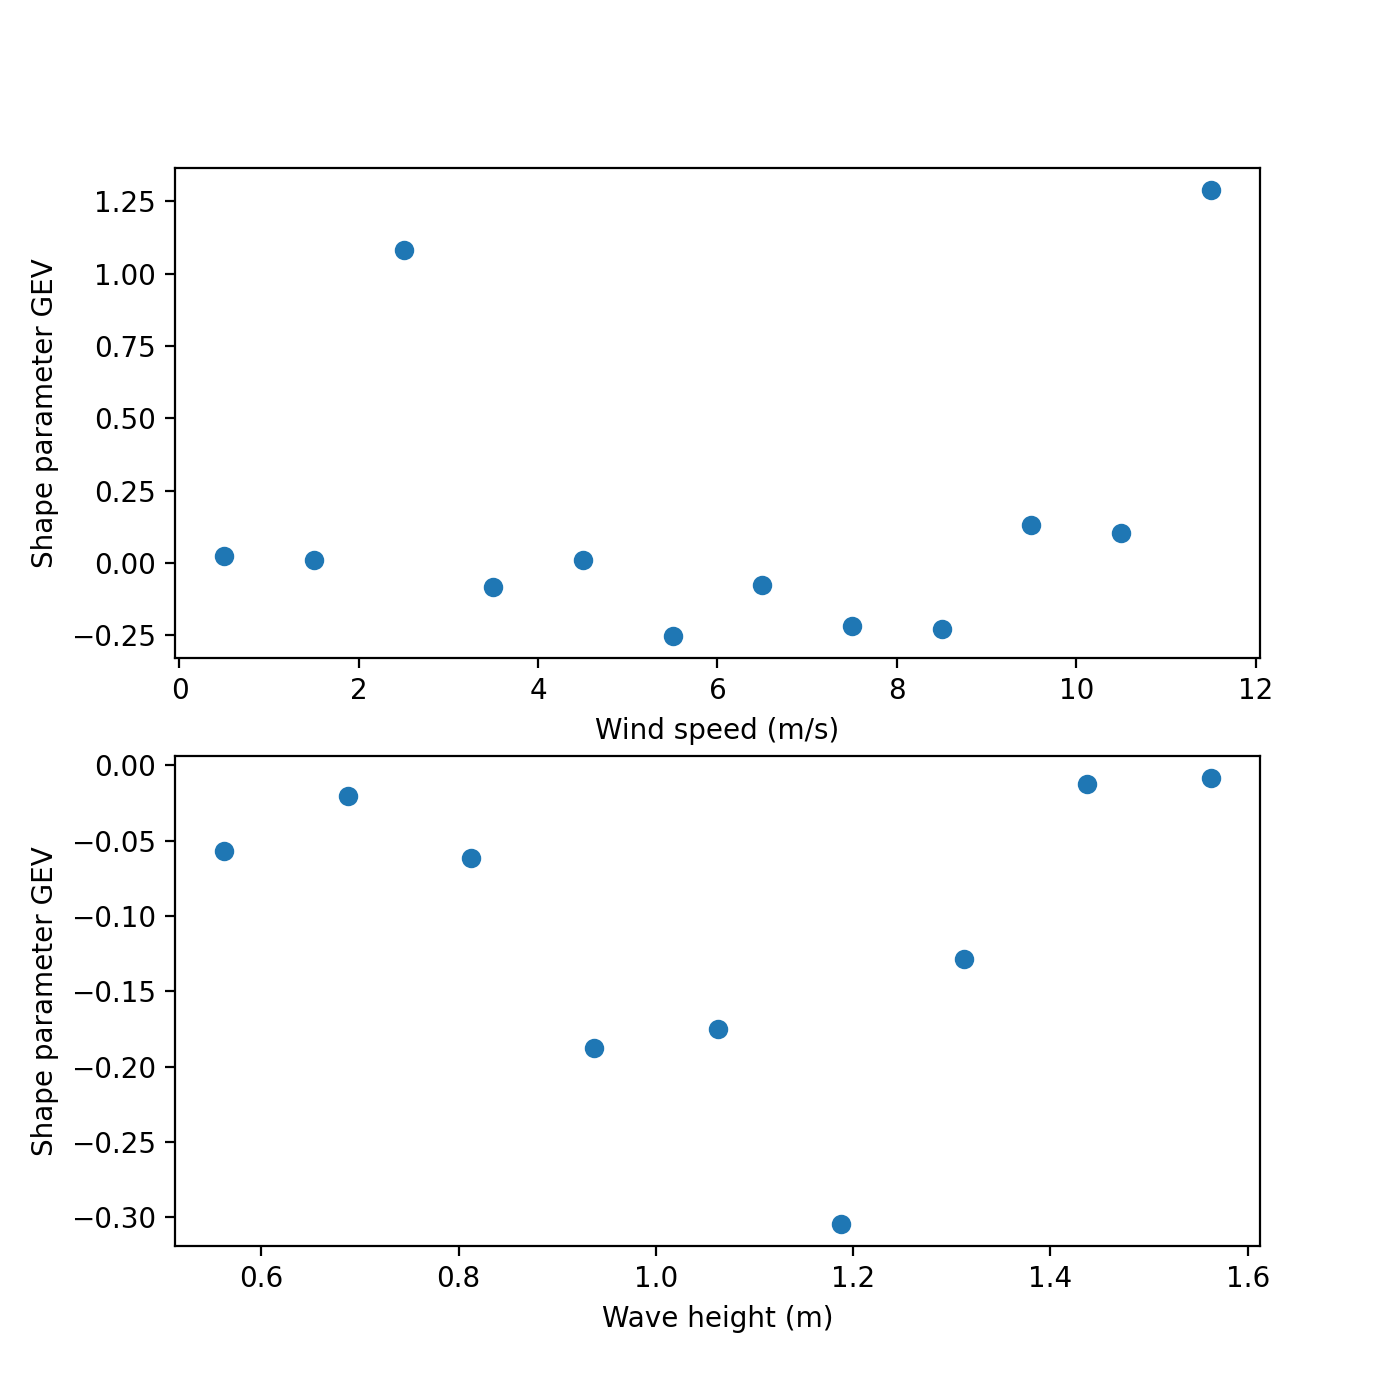

Text(0, 0.5, 'Shape parameter GEV')

In [143]:
fig, (ax1, ax2) = plt.subplots(2, sharex= False, figsize=(7,7))
ax1.scatter(wind_references, parameter_list_tower_V[0])
ax1.set_xlabel('Wind speed (m/s)')
ax1.set_ylabel('Shape parameter GEV')
ax2.scatter(waveH_references, parameter_list_tower_Hs[0])
ax2.set_xlabel('Wave height (m)')
ax2.set_ylabel('Shape parameter GEV')

# Dependency Location parameter

<IPython.core.display.Javascript object>


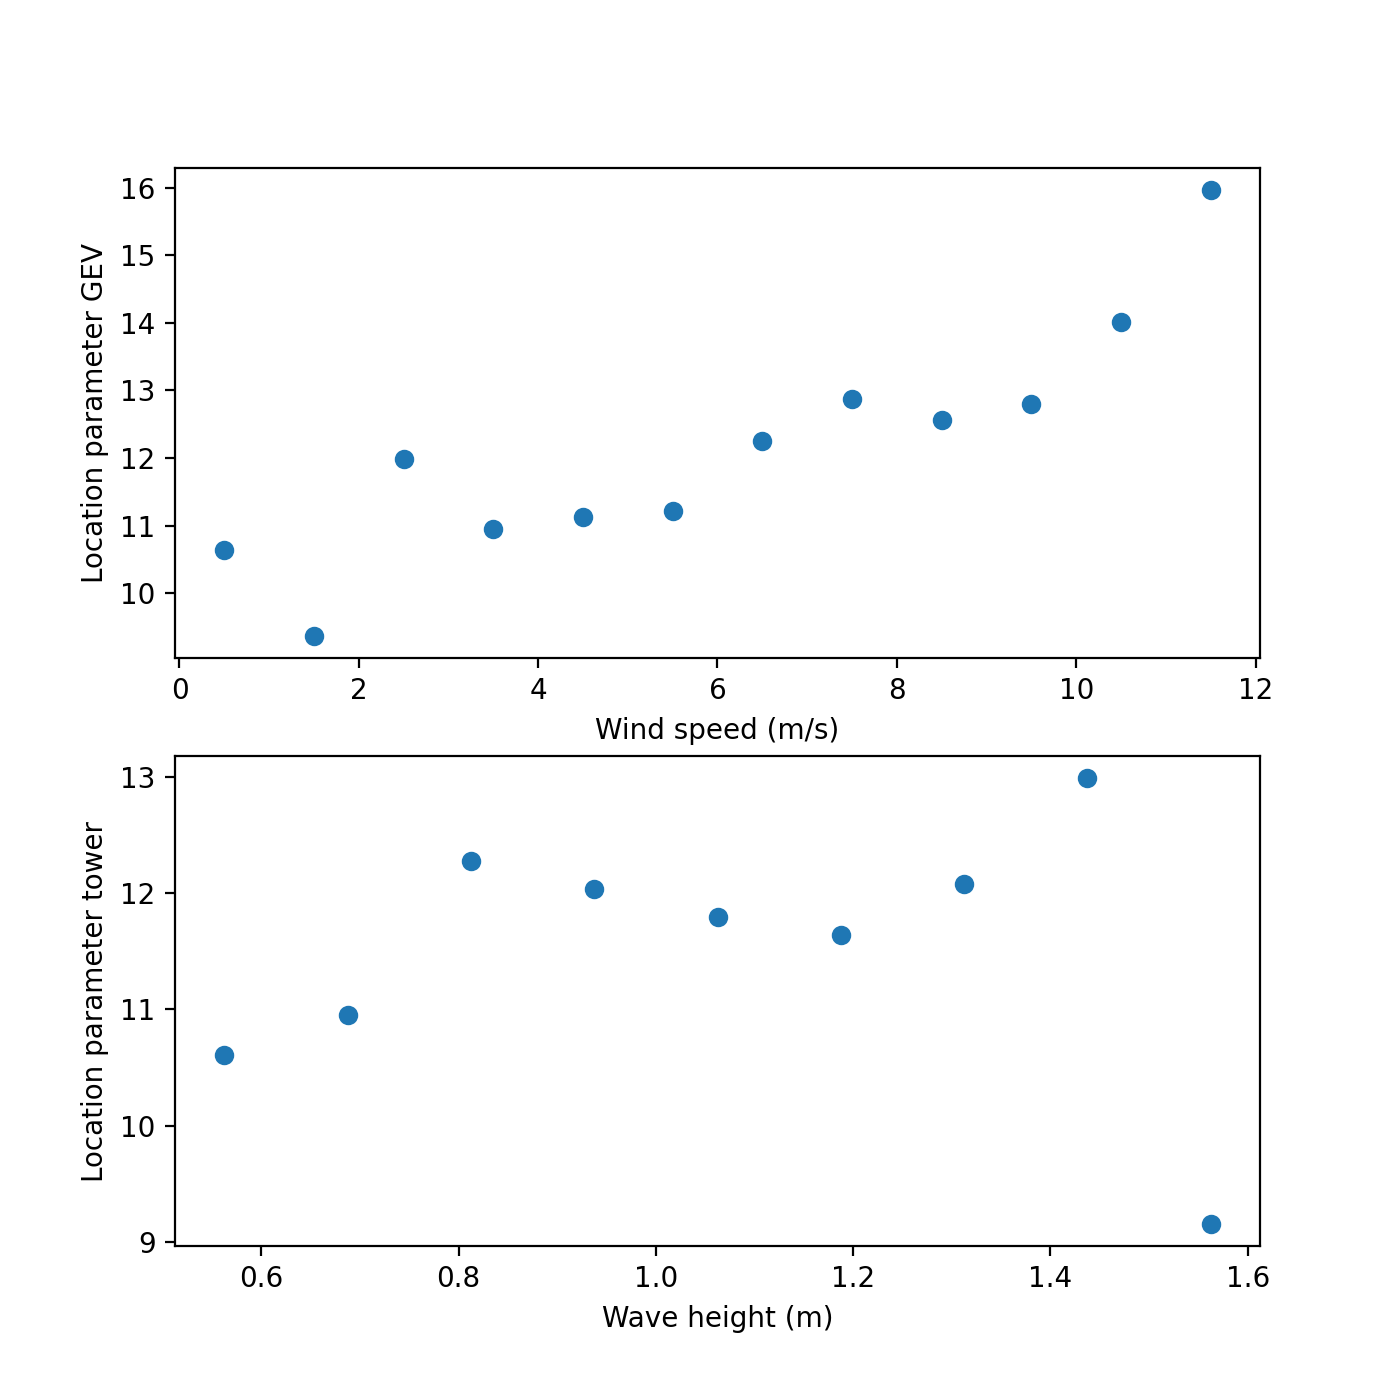

Text(0, 0.5, 'Location parameter tower')

In [144]:
fig, (ax1, ax2) = plt.subplots(2, sharex= False, figsize=(7,7))
ax1.scatter(wind_references, parameter_list_tower_V[1])
ax1.set_xlabel('Wind speed (m/s)')
ax1.set_ylabel('Location parameter GEV')

ax2.scatter(waveH_references, parameter_list_tower_Hs[1])
ax2.set_xlabel('Wave height (m)')
ax2.set_ylabel('Location parameter tower')

In [145]:
parameter_list_tower_Hs[1][-1]= parameter_list_tower_Hs[1][-2]

# Dependency Scale parameter

<IPython.core.display.Javascript object>


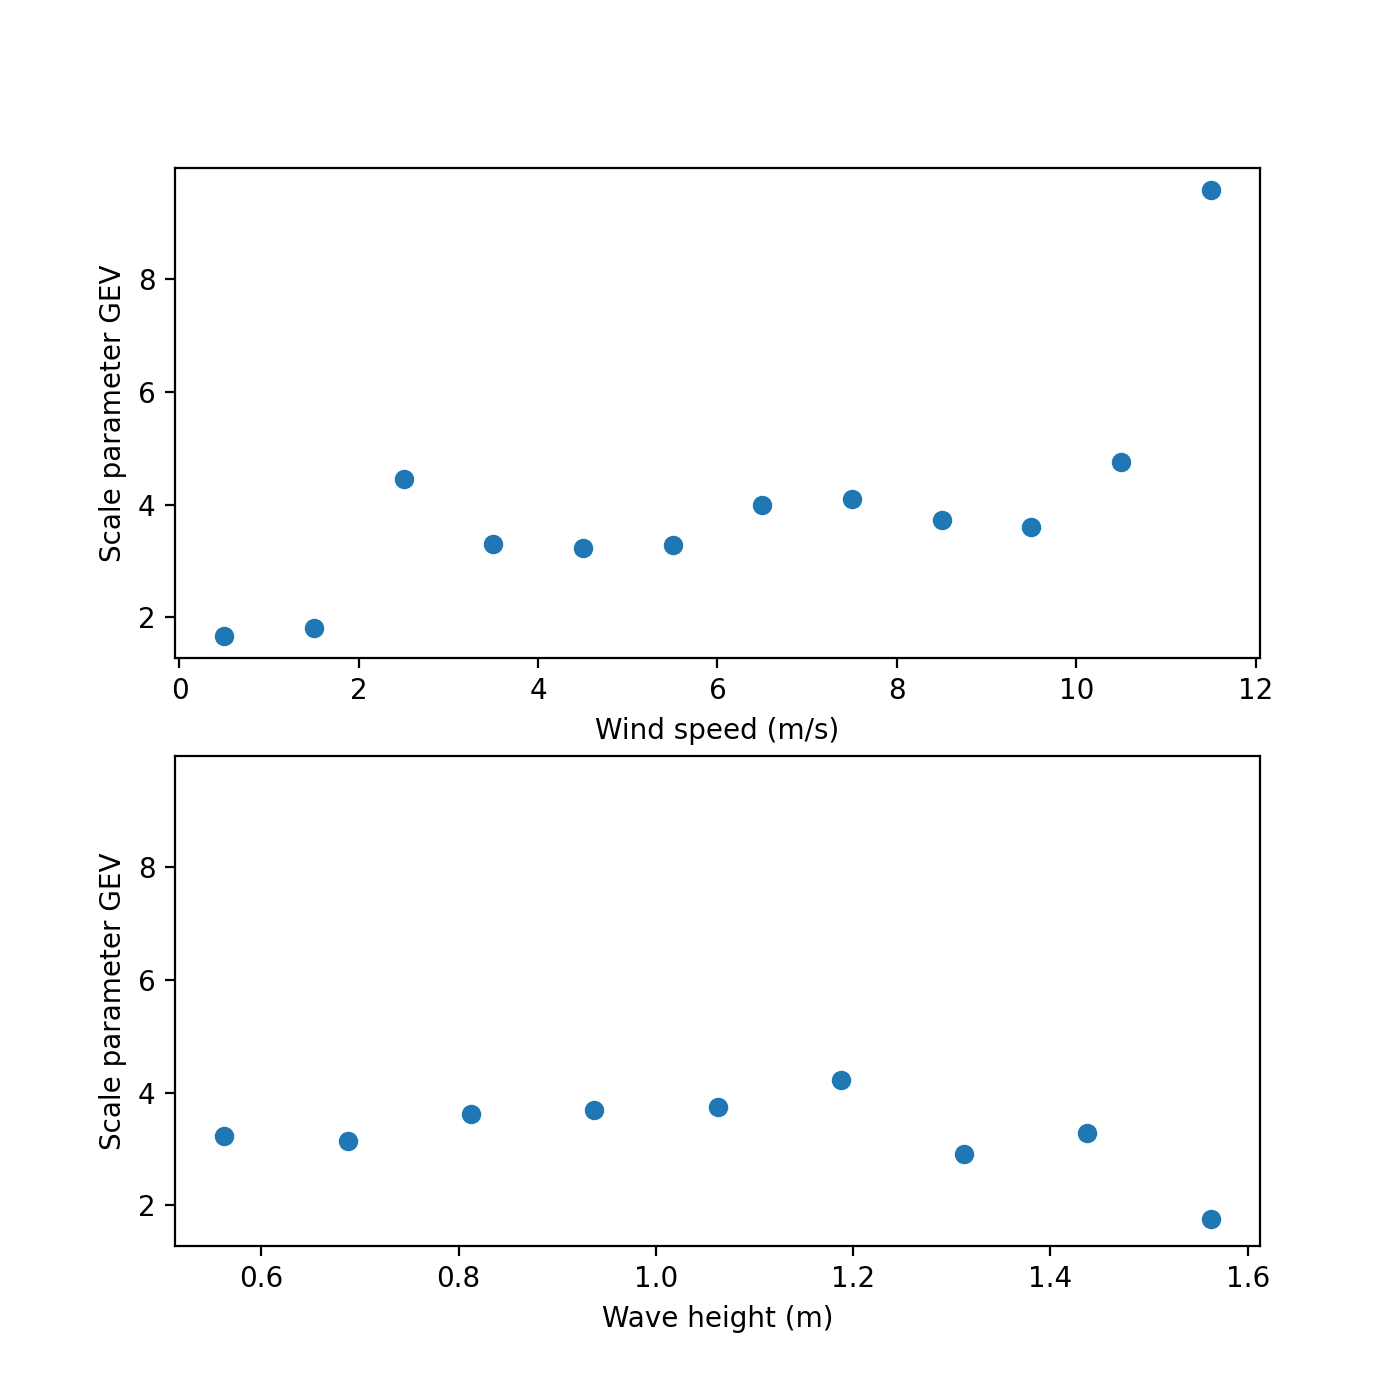

Text(0, 0.5, 'Scale parameter GEV')

In [146]:
fig, (ax1, ax2) = plt.subplots(2, sharey=True, sharex= False, figsize=(7,7))
ax1.scatter(wind_references, parameter_list_tower_V[2])
ax1.set_xlabel('Wind speed (m/s)')
ax1.set_ylabel('Scale parameter GEV')
ax2.scatter(waveH_references, parameter_list_tower_Hs[2])
ax2.set_xlabel('Wave height (m)')
ax2.set_ylabel('Scale parameter GEV')

# Correlation coefficients

In [147]:
# WIND

r_shape_wind = np.corrcoef(parameter_list_tower_V[0], wind_references)
r_location_wind = np.corrcoef(parameter_list_tower_V[1], wind_references)
r_scale_wind = np.corrcoef(parameter_list_tower_V[2], wind_references)
print(r_shape_wind)
print(r_location_wind)
print(r_scale_wind)

[[1.         0.17340823]
 [0.17340823 1.        ]]
[[1.         0.88222199]
 [0.88222199 1.        ]]
[[1.         0.71268318]
 [0.71268318 1.        ]]


In [148]:
# WAVE HEIGHT

r_shape_waveH = np.corrcoef(parameter_list_tower_Hs[0], waveH_references)
r_location_waveH = np.corrcoef(parameter_list_tower_Hs[1], waveH_references)
r_scale_waveH = np.corrcoef(parameter_list_tower_Hs[2], waveH_references)
print(r_shape_waveH)
print(r_location_waveH)
print(r_scale_waveH)

[[ 1.         -0.01560159]
 [-0.01560159  1.        ]]
[[1.         0.84031003]
 [0.84031003 1.        ]]
[[ 1.         -0.41588073]
 [-0.41588073  1.        ]]


# Dependence Functions

In [149]:
# Define dependence functions

def _power3(x, a, b, c):
    return a + b * x ** c
def _linear(x, a, b):
    return x * a + b
def _exp3(x, a, b, c):
    return a + b * np.exp(c * x)


bounds_3p = [(None, None), (None, None), (None, None)]
bounds_2p = [(None, None), (None, None)]
exp_bounds = [(0, None), (0, None), (None, None)]

power3 = DependenceFunction(_power3, bounds_3p, latex="$a + b * x^c$")
linear = DependenceFunction(_linear, latex="$a + b * x$")
exp3 = DependenceFunction(_exp3, bounds=exp_bounds)

In [150]:
#shape_param_fit= linear.fit(wind_references, parameter_list[0])
#print(shape_param_fit)

#linear.fit(wind_references, parameter_list[0])
#print(linear)

### WIND

In [151]:
wind_ref= np.asarray(wind_references)
shape_wind= np.asarray(parameter_list_tower_V[0])
location_wind= np.asarray(parameter_list_tower_V[1])
scale_wind= np.asarray(parameter_list_tower_V[2])

#print(shape_wind)

In [152]:
linear_param_wind1 = fit_function(linear, wind_ref, shape_wind, (1, 1), "lsq", None, None)
linear_param_wind2 = fit_function(linear, wind_ref, location_wind, (1, 1), "lsq", None, None)
linear_param_wind3 = fit_function(linear, wind_ref, scale_wind, (1, 1), "lsq", None, None)
print(linear_param_wind1)
print(linear_param_wind2)
print(linear_param_wind3)

[0.02413338 0.0046308 ]
[0.42106466 9.61953487]
[0.39495517 1.58860429]


<IPython.core.display.Javascript object>


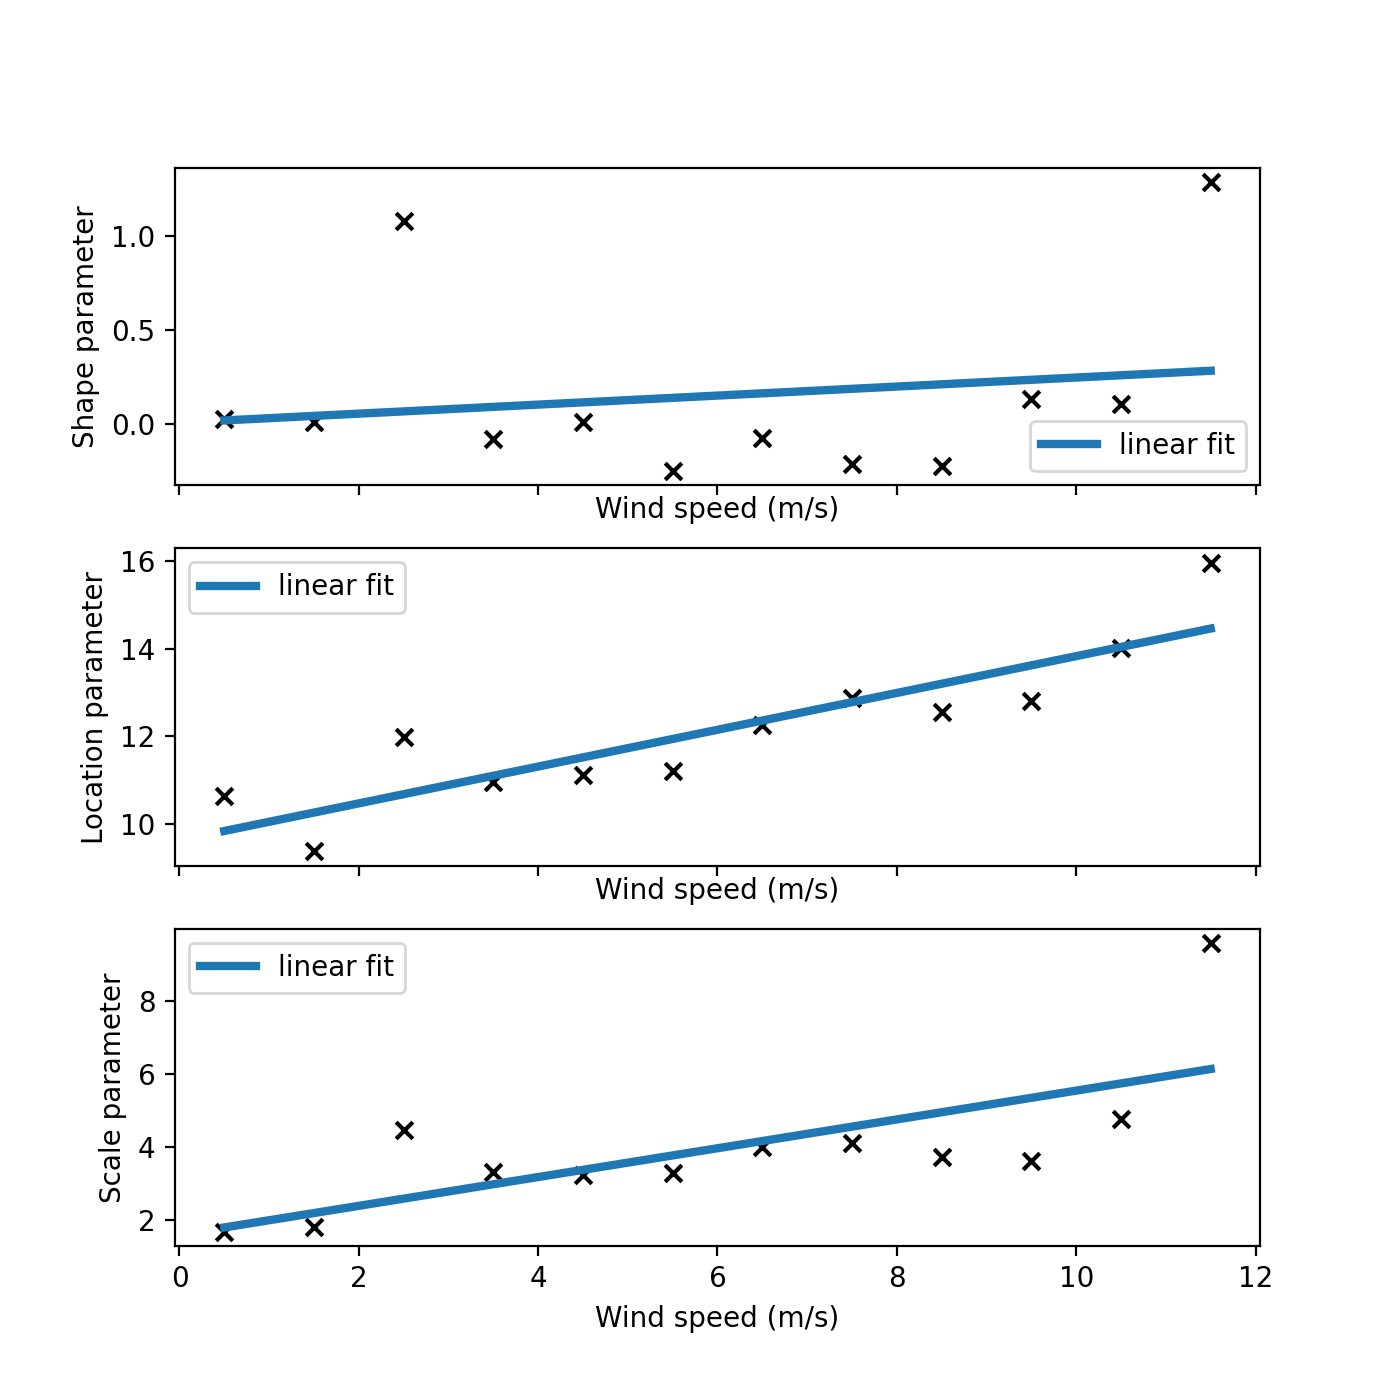

In [153]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex= True, figsize=(7,7))
ax1.scatter(wind_ref, shape_wind, marker="x", c="k")
ax1.plot(wind_ref, linear(wind_ref, *linear_param_wind1), label="linear fit", linewidth=3)
ax1.set_xlabel('Wind speed (m/s)')
ax1.set_ylabel('Shape parameter')
ax2.scatter(wind_ref, location_wind, marker="x", c="k")
ax2.plot(wind_ref, linear(wind_ref, *linear_param_wind2), label="linear fit", linewidth=3)
ax2.set_xlabel('Wind speed (m/s)')
ax2.set_ylabel('Location parameter')
ax3.scatter(wind_ref, scale_wind, marker="x", c="k")
ax3.plot(wind_ref, linear(wind_ref, *linear_param_wind3), label="linear fit", linewidth=3)
ax3.set_xlabel('Wind speed (m/s)')
ax3.set_ylabel('Scale parameter')

ax1.legend()
ax2.legend()
ax3.legend()

### WAVE HEIGHT

In [154]:
waveH_ref= np.asarray(waveH_references)
shape_waveH= np.asarray(parameter_list_tower_Hs[0])
location_waveH= np.asarray(parameter_list_tower_Hs[1])
scale_waveH= np.asarray(parameter_list_tower_Hs[2])

In [155]:
linear_param_waveH1 = fit_function(linear, waveH_ref, shape_waveH, (1, 1), "lsq", None, None)
linear_param_waveH2 = fit_function(linear, waveH_ref, location_waveH, (1, 1), "lsq", None, None)
linear_param_waveH3 = fit_function(linear, waveH_ref, scale_waveH, (1, 1), "lsq", None, None)
print(linear_param_waveH1)
print(linear_param_waveH2)
print(linear_param_waveH3)

[-0.0045892  -0.10119567]
[1.97875058 9.82487112]
[-0.84316748  4.18521024]


<IPython.core.display.Javascript object>


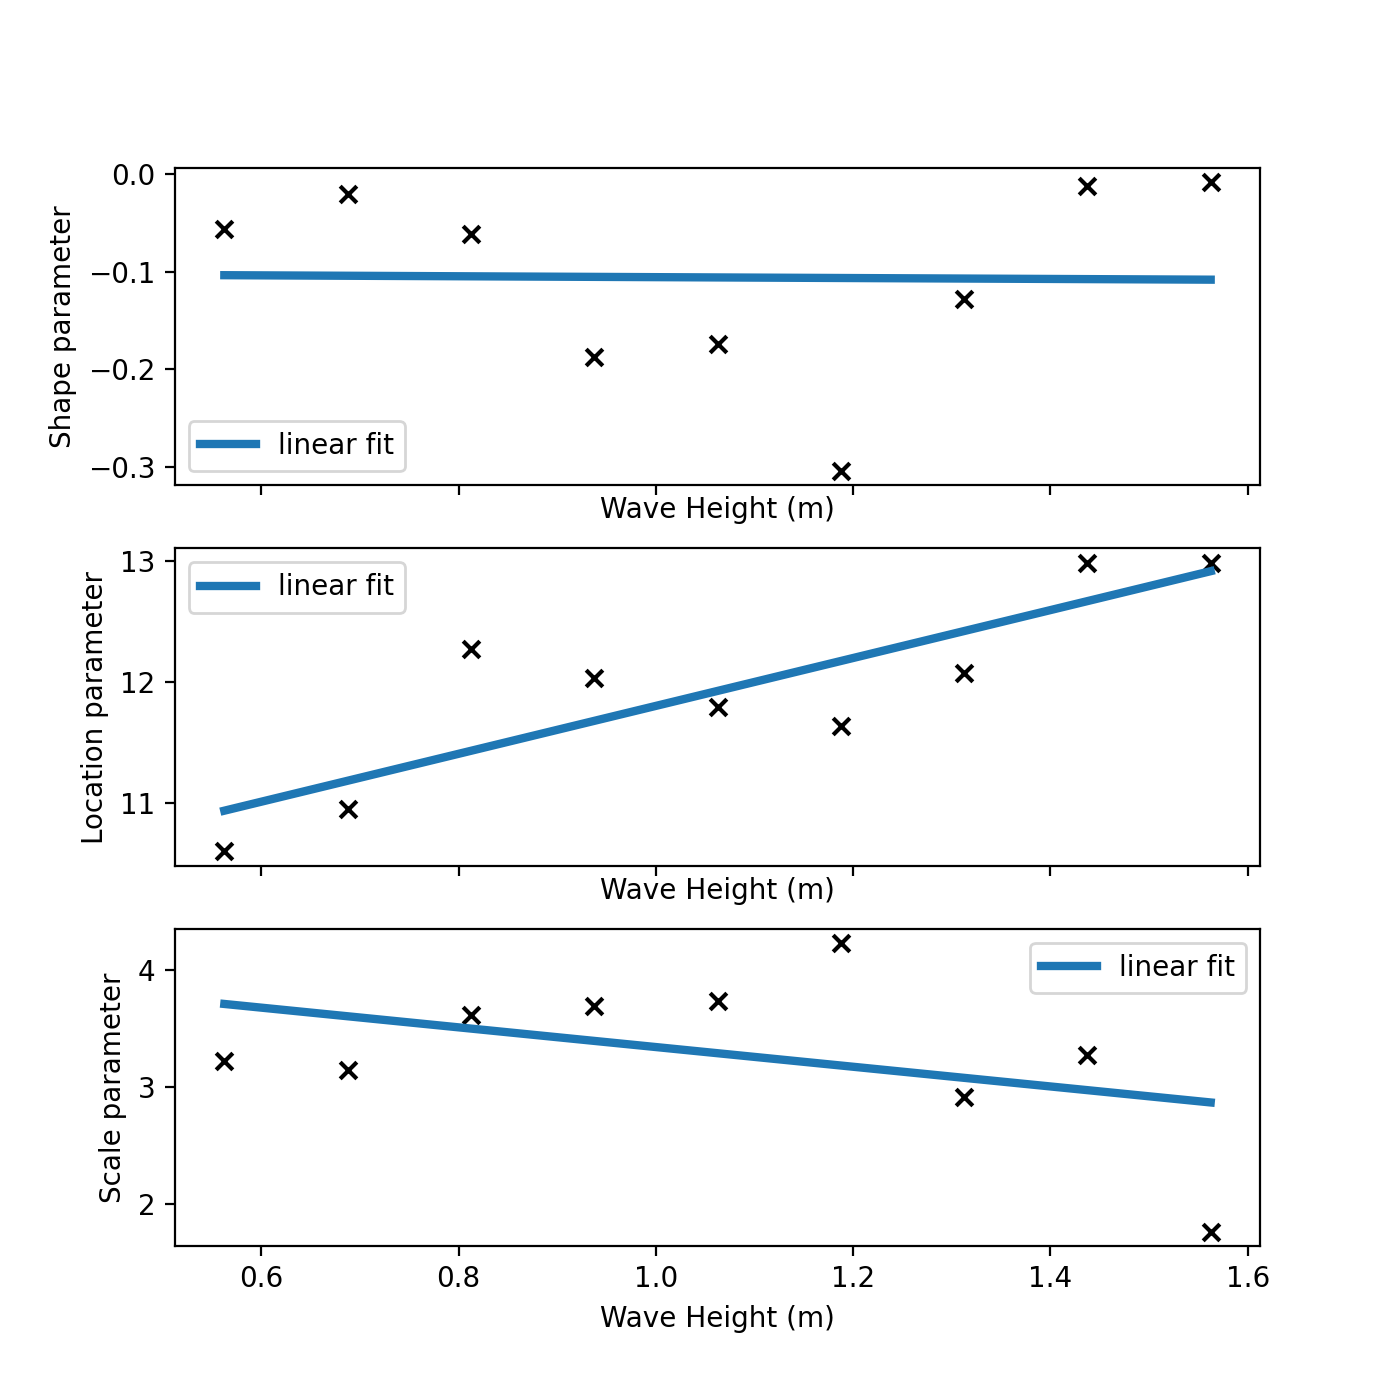

In [156]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex= True, figsize=(7,7))
ax1.scatter(waveH_ref, shape_waveH, marker="x", c="k")
ax1.plot(waveH_ref, linear(waveH_ref, *linear_param_waveH1), label="linear fit", linewidth=3)
ax1.set_xlabel('Wave Height (m)')
ax1.set_ylabel('Shape parameter')
ax2.scatter(waveH_ref, location_waveH, marker="x", c="k")
ax2.plot(waveH_ref, linear(waveH_ref, *linear_param_waveH2), label="linear fit", linewidth=3)
ax2.set_xlabel('Wave Height (m)')
ax2.set_ylabel('Location parameter')
ax3.scatter(waveH_ref, scale_waveH, marker="x", c="k")
ax3.plot(waveH_ref, linear(waveH_ref, *linear_param_waveH3), label="linear fit", linewidth=3)
ax3.set_xlabel('Wave Height (m)')
ax3.set_ylabel('Scale parameter')

ax1.legend()
ax2.legend()
ax3.legend()

# Modell 1: R(Hs)

In [157]:
# Average scale and shape 

average_xi= shape_waveH.mean()
average_sigma= scale_waveH.mean()
print(average_xi)
print(average_sigma)
print(gev_fit_tower[0])
print(gev_fit_tower[2])

-0.10607169128666967
3.2893447882321687
-0.1118007401397142
3.496913938662952


In [158]:
def mu_func2D(hs):
    return linear_param_waveH2[0]*hs +linear_param_waveH2[1]
#def sigma_func(hs):
    #return -0.635*hs +4.497

In [159]:
#xi= xi_func(data.waveHeight)
mu2D= mu_func2D(data.waveHeight)
#sigma= sigma_func(data.waveHeight)
print(mu2D)

0      12.575334
1      12.575334
2      12.575334
3      12.575334
4      12.575334
         ...    
795    10.893396
796    10.893396
797    10.893396
798    10.893396
799    10.893396
Name: waveHeight, Length: 800, dtype: float64


In [161]:
con_dist_Hs= stats.genextreme(gev_fit_tower[0], mu2D, gev_fit_tower[2])
#cdf=joint_dist.cdf(r_grid)
#pdf=joint_dist.pdf(r_grid)
#rvs=joint_dist.rvs(size=(20,20))
sample_size= tuple([len(data)])
rvs_2D= con_dist_Hs.rvs(size=sample_size)
#print(con_dist_Hs)
print(type(rvs_2D))
print(rvs_2D)

<class 'numpy.ndarray'>
[21.99737892 10.67700303 12.31808311 22.02839385 24.52185659 14.4200844
  9.81696854 24.71617294 14.18295428 19.73199947 12.55974239 16.63685193
 10.95851984 13.33504874  9.85877871 19.01735346 10.72253386 17.72298454
 13.38840108 12.51715195 13.84637592 15.14285819 16.55433856 11.69968677
 11.70014593 12.78979323 13.56998976  8.70668607  8.84233559 10.77766467
 14.8063202  12.985298    9.76770844 17.28662678 12.28384865 10.21052423
 12.64384486 17.73580805 18.90113553 15.44703892 10.40587903 13.73275905
 20.06962277 18.38482391 18.00263165  9.50040714 10.62446152 24.51420837
 20.9854475  14.48279502 16.16664931 18.1560952  18.28572491 18.17038219
 10.13990975 13.25279472 11.94596649 10.40419611 18.92509914  8.77966284
 12.42845095 11.59930788 10.92237663  7.13186998 15.32094347  9.91205748
 18.17123261 12.10741282  9.41162128  8.64175165  8.95251027  8.38043459
 21.17471762 20.32938665 12.43416464  9.59940576 19.08190559 25.77384319
  9.14767921 10.56198196  9.

In [163]:
peak_defl_tower= pd.DataFrame.to_numpy(data.peakDeflectionTower)
#print(peak_defl_tower)
model_error= peak_defl_tower-rvs_2D
model_error= abs(model_error)
model_error_mean= model_error.mean()
print(model_error_mean)

4.915074097211943


## Comparison real data and model

<IPython.core.display.Javascript object>


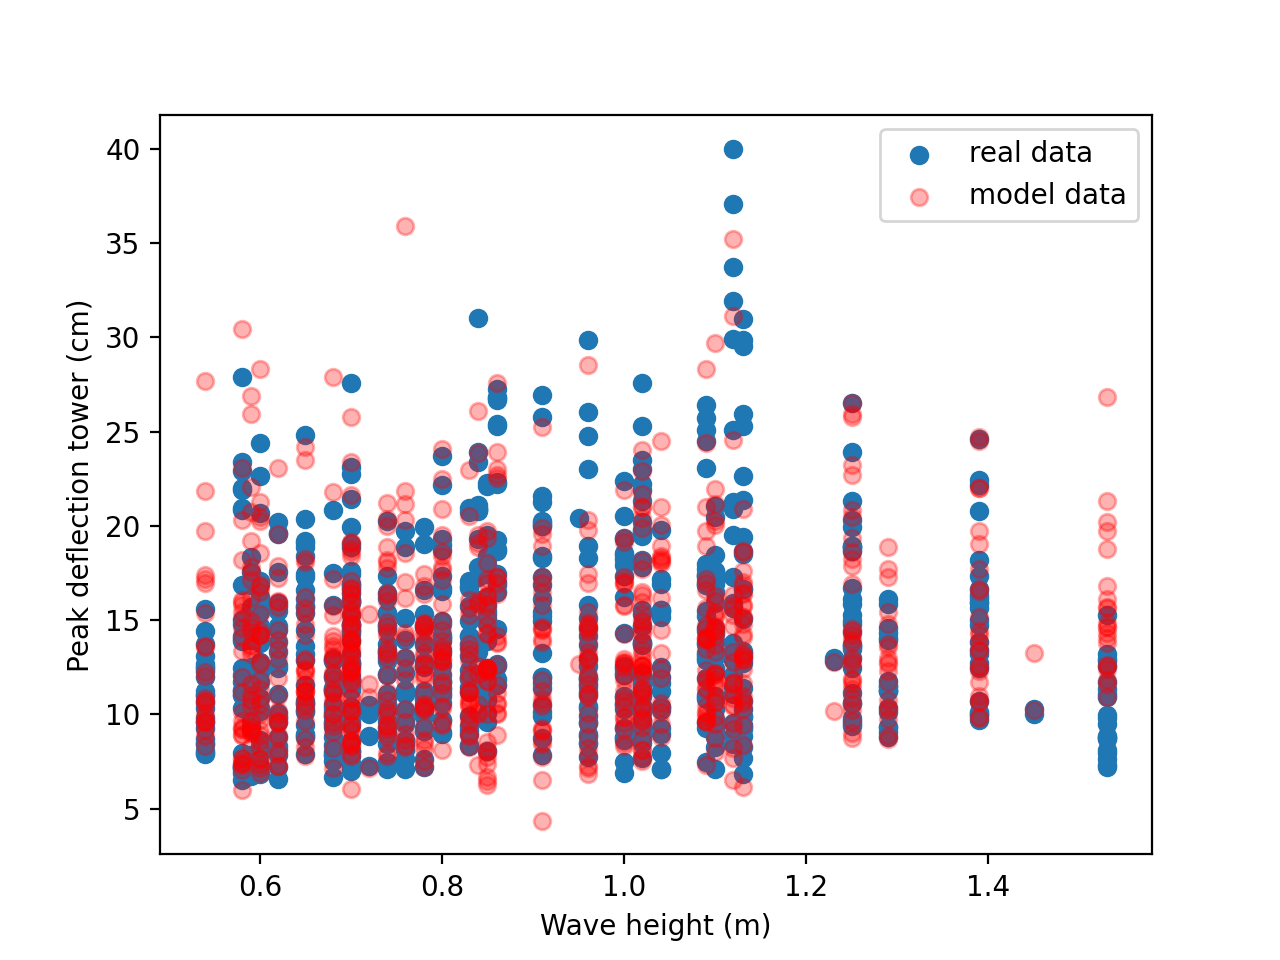

In [165]:
plt.figure()
plt.scatter(data.waveHeight, data.peakDeflectionTower, label='real data')
plt.scatter(data.waveHeight, rvs_2D, alpha=0.3, color= 'r', label='model data')
plt.xlabel('Wave height (m)')
plt.ylabel('Peak deflection tower (cm)')
plt.legend()

## Goddness of fit

In [166]:
print(data.peakDeflectionTower.mean())
print(np.mean(rvs_2D))

print(data.peakDeflectionTower.median())
print(np.median(rvs_2D))

13.894361000000002
13.747336282548906
12.77685
12.93080430474454


<IPython.core.display.Javascript object>


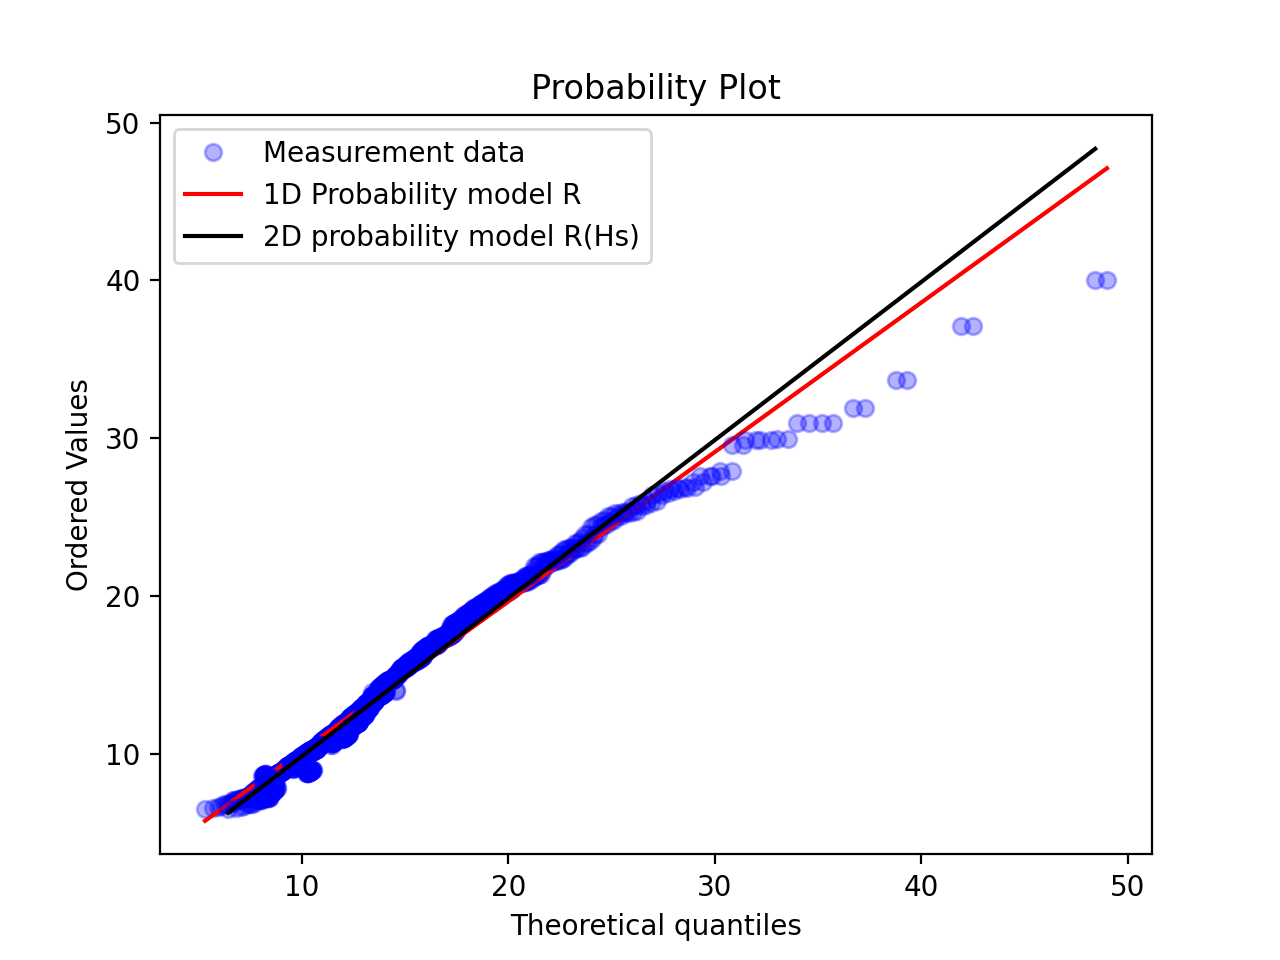

In [193]:
fig = plt.figure()
ax = fig.add_subplot(111)
stats.probplot(data.peakDeflectionTower, (gev_fit_tower[0], gev_fit_tower[1], gev_fit_tower[2]), dist='genextreme', plot=ax)
stats.probplot(data.peakDeflectionTower, (gev_fit_tower[0], mu2D, gev_fit_tower[2]), dist='genextreme', plot=ax)
#ax.set_title("Probability plot of sample data against the quantiles of a specified theoretical distribution.")

ax.get_lines()[0].set_markerfacecolor('b')
ax.get_lines()[0].set_alpha(0.3)
ax.get_lines()[2].set_alpha(0.3)
ax.get_lines()[3].set_color('black')
ax.get_lines()[0].set_label('Measurement data')
ax.get_lines()[1].set_label('1D Probability model R')
ax.get_lines()[3].set_label('2D probability model R(Hs)')

ax.legend()
plt.show()

# Modell 2: R(Hs,V)

Idee: 
- shape, location und scale parameter auf ein zweidimensionales Koordinatensystem aus hs und v intervallen fitten
- dann basierend auf den Intervallen eine gemeinsame Abhängigkeit (Ebene) fitten

<IPython.core.display.Javascript object>


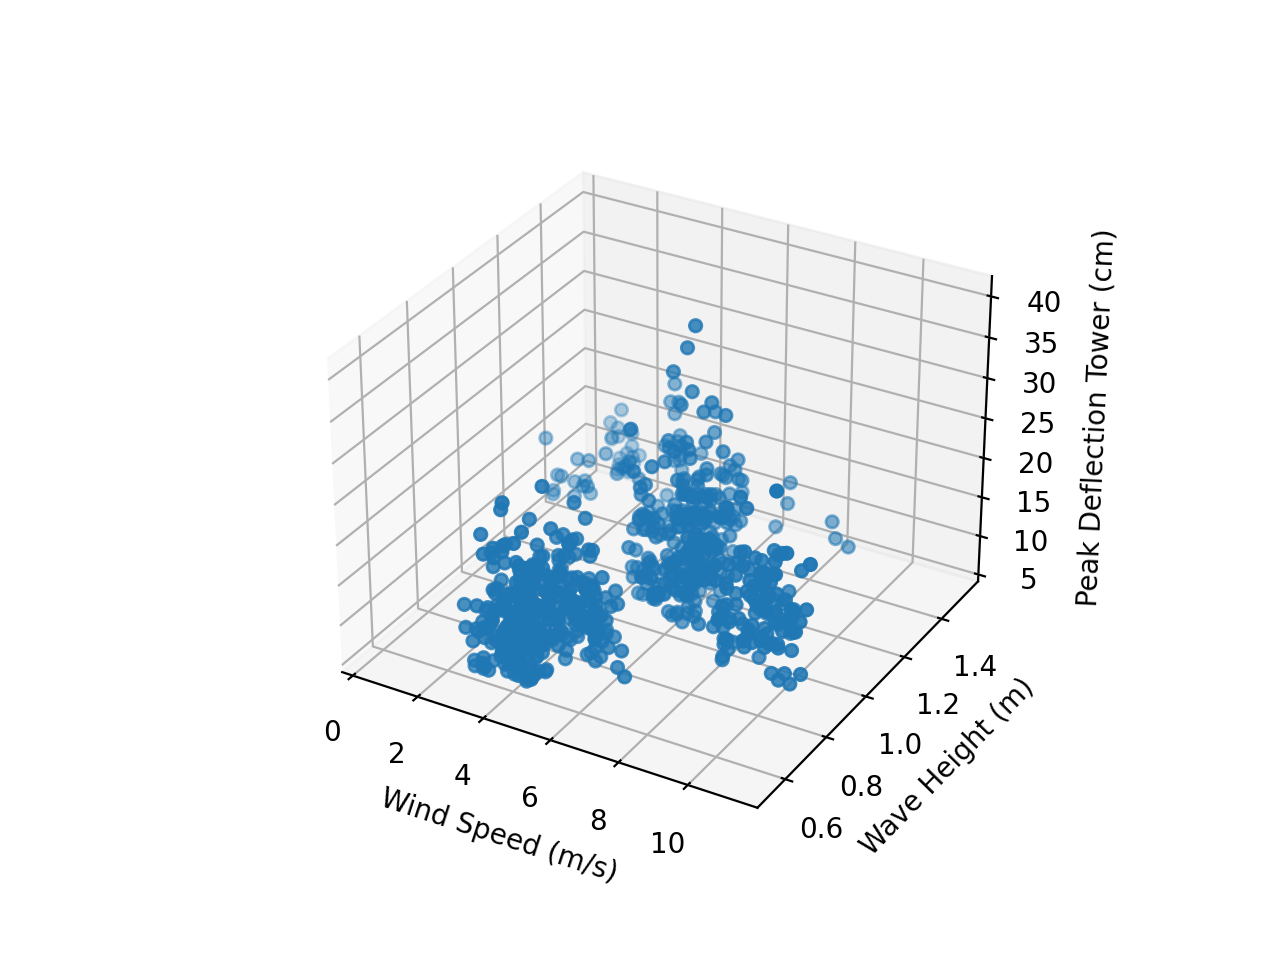

Text(0.5, 0, 'Peak Deflection Tower (cm)')

In [194]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
xs = data.windSpeed
ys = data.waveHeight
zs = data.peakDeflectionTower
ax.scatter(xs, ys, zs)
ax.set_xlabel('Wind Speed (m/s)')
ax.set_ylabel('Wave Height (m)')
ax.set_zlabel('Peak Deflection Tower (cm)')

In [195]:
width_slicer_V2 = WidthOfIntervalSlicer(width=2.5, reference="right", min_n_points=1)
width_slicer_Hs2 = WidthOfIntervalSlicer(width=0.5, reference="right", min_n_points=1)

wind_slices2, wind_references2, wind_boundaries2 = width_slicer_V2.slice_(data.windSpeed)
waveH_slices2, waveH_references2, waveH_boundaries2 = width_slicer_Hs2.slice_(data.waveHeight)

print(wind_boundaries2)
print(waveH_boundaries2)
print(type(len(wind_boundaries2)))

[(1.25, 3.75), (3.75, 6.25), (6.25, 8.75), (8.75, 11.25)]
[(0.25, 0.75), (0.75, 1.25), (1.25, 1.75)]
<class 'int'>


In [196]:
# This for loop does the following:
# 1. Find peak deflection data that are simultaneously in a certain interval of both hs and v 
# 2. Estimate the parameters of the GEV distribution of that specific interval
# 3. Sort the parameters into matrices of shape, scale and location parameter

shape_matrix = np.empty((len(wind_boundaries2), len(waveH_boundaries2)))
shape_matrix[:] = np.NaN

scale_matrix = np.empty((len(wind_boundaries2), len(waveH_boundaries2)))
scale_matrix[:] = np.NaN

location_matrix = np.empty((len(wind_boundaries2), len(waveH_boundaries2)))
location_matrix[:] = np.NaN


for j in range (len(wind_references2)):
    for k in range (len(waveH_references2)):
        data_storage= []
        for i in range(len(data)):
            if ((data.windSpeed[i] >= wind_boundaries2[j][0]) & (data.windSpeed[i] < wind_boundaries2[j][1]) & (data.waveHeight[i] >= waveH_boundaries2[k][0]) & (data.waveHeight[i] < waveH_boundaries2[k][1]) ):
                data_storage.append(data.peakDeflectionTower[i])

        if len(data_storage)== 0:
            data_storage.append(data.peakDeflectionTower[i])
            data_storage.append(data.peakDeflectionTower[i])

        #print(data_storage)
        #print(len(data_storage))
        fit= stats.genextreme.fit(data_storage)
        shape_matrix[j][k]= fit[0]
        scale_matrix[j][k]= fit[1]
        location_matrix[j][k]= fit[2]

/Applications/anaconda3/envs/env_masterthese/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:406: RuntimeWarning: invalid value encountered in double_scalars
  return m3 / np.power(m2, 1.5)
/Applications/anaconda3/envs/env_masterthese/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2492: RuntimeWarning: invalid value encountered in subtract
  -pex2+logpex2-logex2)


In [197]:
#print(shape_matrix)
#print(scale_matrix)
#print(location_matrix)

In [198]:
# This for loop writes the values of the shape, scale and location parameter into vectors with the corresponding
# wave height and wind speed. 

shape_vector= []
scale_vector= []
location_vector= []

for i in range(len(wind_boundaries2)):
    for j in range(len(waveH_boundaries2)):
        for k in range(len(wind_boundaries2)*len(waveH_boundaries2)):
            shape_storage= []
            scale_storage= []
            location_storage= []
            shape_storage.append([shape_matrix[i][j],wind_references2[i], waveH_references[j]])
            scale_storage.append([scale_matrix[i][j],wind_references2[i], waveH_references[j]])
            location_storage.append([location_matrix[i][j],wind_references2[i], waveH_references[j]])
        shape_vector.append(shape_storage)
        scale_vector.append(scale_storage)
        location_vector.append(location_storage)

#print(shape_vector)
#print(shape_vector[0])

In [199]:
# This loop brings the vectors above in a matrix of R|Hs|V 

shape_data = np.empty((len(shape_vector),3))
shape_data[:] = np.NaN

scale_data = np.empty((len(scale_vector),3))
scale_data[:] = np.NaN

location_data = np.empty((len(location_vector),3))
location_data[:] = np.NaN

k=0
for i in range(len(wind_boundaries2)):
    for j in range(len(waveH_boundaries2)):
        shape_data[k][0]= shape_matrix[i][j]
        shape_data[k][1]= waveH_references2[j]
        shape_data[k][2]= wind_references2[i]
        
        scale_data[k][0]= scale_matrix[i][j]
        scale_data[k][1]= waveH_references2[j]
        scale_data[k][2]= wind_references2[i]
        
        location_data[k][0]= location_matrix[i][j]
        location_data[k][1]= waveH_references2[j]
        location_data[k][2]= wind_references2[i]
        k=k+1

In [200]:
print(shape_data)
#print(scale_data)
#print(location_data)

[[-0.01849123  0.5         2.5       ]
 [ 1.44030391  1.          2.5       ]
 [-0.15493112  1.5         2.5       ]
 [-0.02753626  0.5         5.        ]
 [-0.23744305  1.          5.        ]
 [-0.06657141  1.5         5.        ]
 [-4.19768138  0.5         7.5       ]
 [-0.06122741  1.          7.5       ]
 [ 0.41397807  1.5         7.5       ]
 [-0.86590519  0.5        10.        ]
 [ 0.01377364  1.         10.        ]
 [ 1.57386679  1.5        10.        ]]


## Modell Shape Parameter

In [201]:
X,Y = np.meshgrid(np.arange(0, 2, 0.5), np.arange(0, 10, 0.5))
XX = X.flatten()
YY = Y.flatten()

# best-fit linear plane
A = np.c_[shape_data[:,1], shape_data[:,2], np.ones(shape_data.shape[0])]
C_shape,_,_,_ = scipy.linalg.lstsq(A, shape_data[:,0])    # coefficients
print(C_shape)

# evaluate it on grid
Z = C_shape[0]*X + C_shape[1]*Y + C_shape[2]

[ 1.7189891  -0.06865092 -1.47224291]


<IPython.core.display.Javascript object>


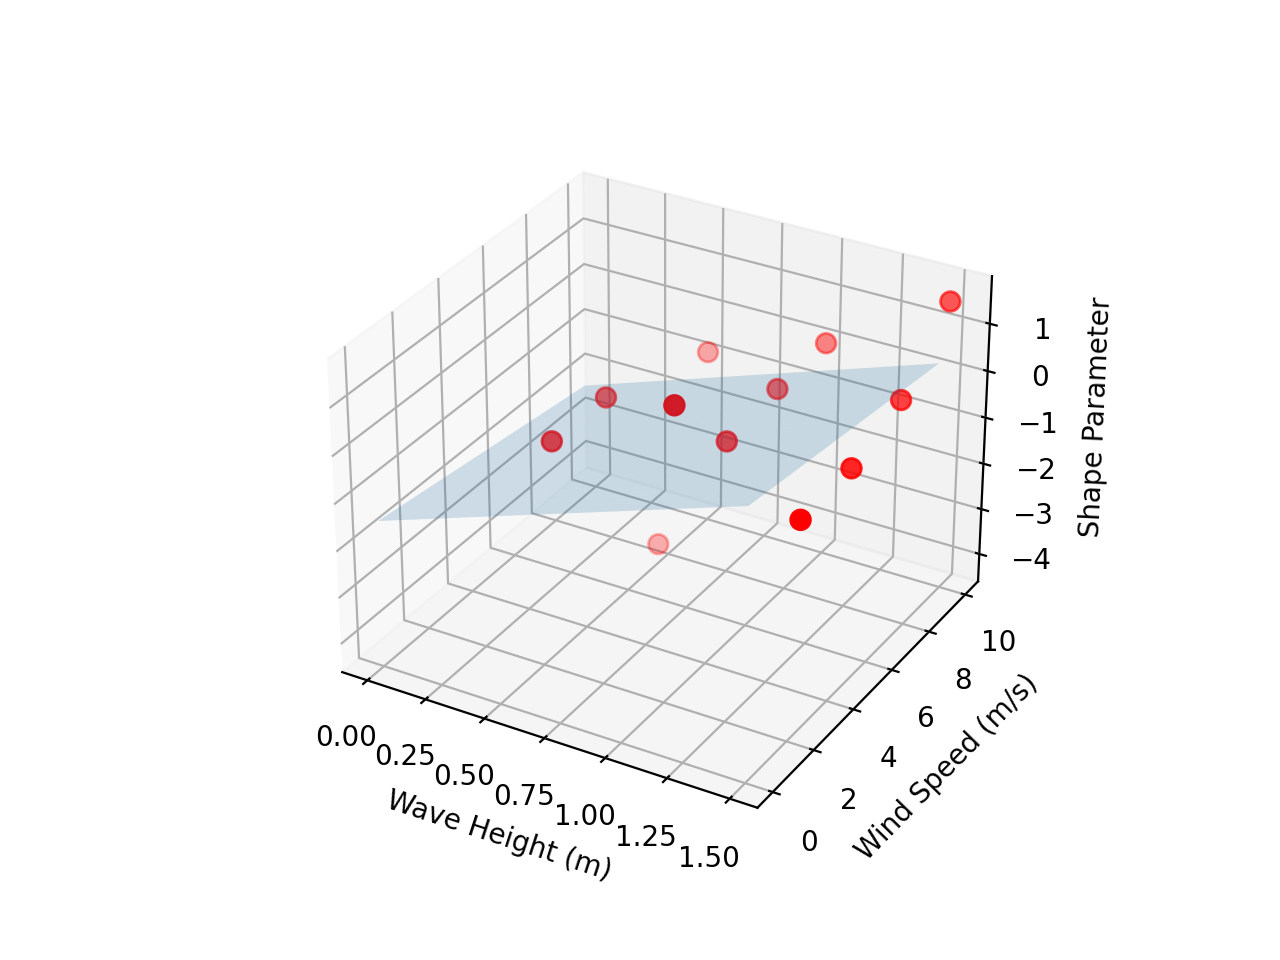

In [202]:
# plot points and fitted surface
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, alpha=0.2)
ax.scatter(shape_data[:,1], shape_data[:,2], shape_data[:,0], c='r', s=50)
plt.xlabel('Wave Height (m)')
plt.ylabel('Wind Speed (m/s)')
ax.set_zlabel('Shape Parameter')
ax.axis('auto')
ax.axis('tight')
plt.show()

## Modell Scale Parameter

In [203]:
X,Y = np.meshgrid(np.arange(0, 2, 0.5), np.arange(0, 10, 0.5))
XX = X.flatten()
YY = Y.flatten()

# best-fit linear plane
A = np.c_[scale_data[:,1], scale_data[:,2], np.ones(scale_data.shape[0])]
C_scale,_,_,_ = scipy.linalg.lstsq(A, scale_data[:,0])    # coefficients
print(C_scale)

# evaluate it on grid
Z = C_scale[0]*X + C_scale[1]*Y + C_scale[2]

[ 2.47135572 -0.07569831  9.32245556]


<ipython-input-204-34bfeffb5ea4>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


<IPython.core.display.Javascript object>


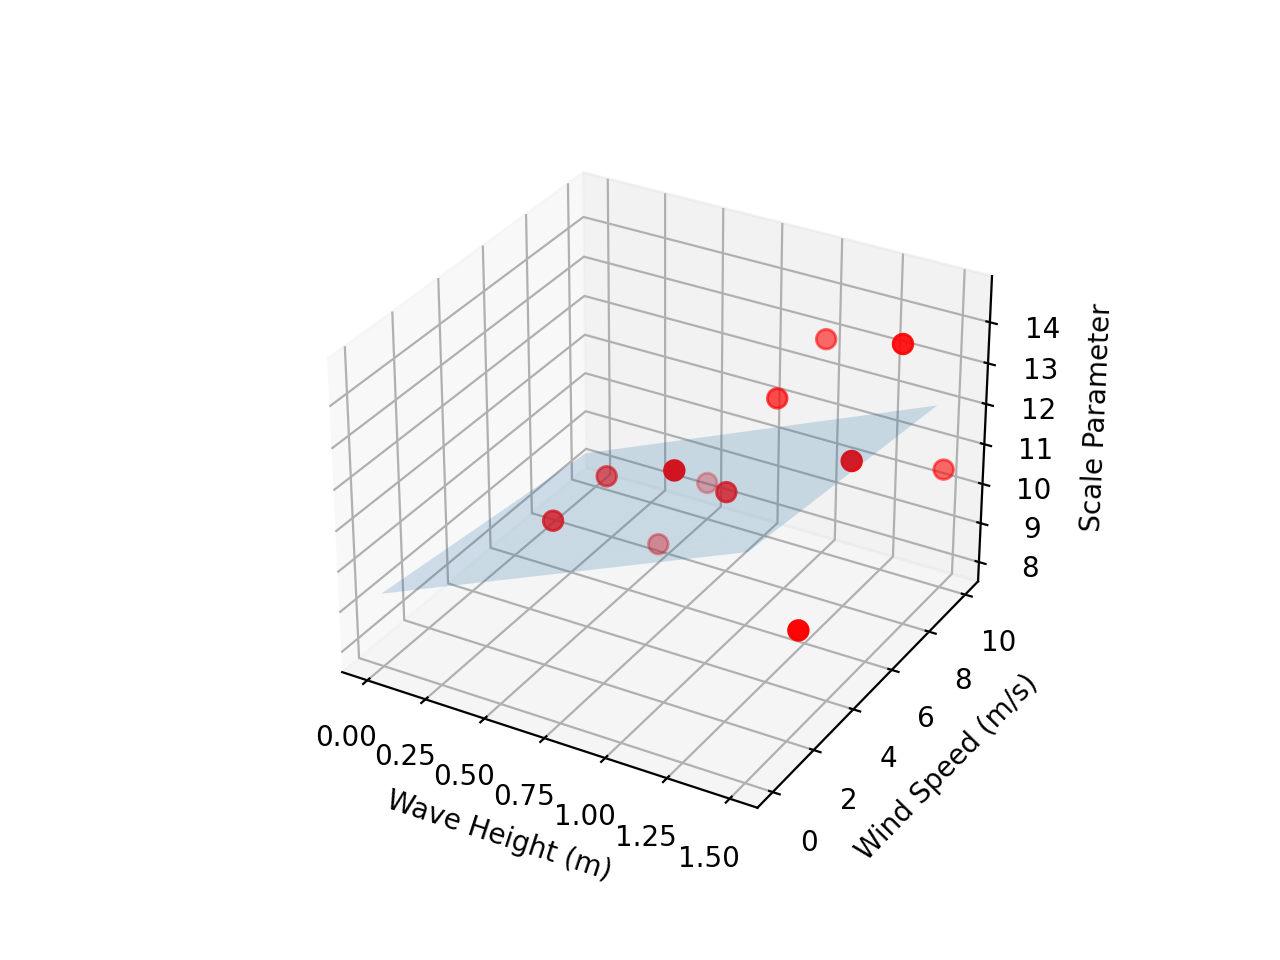

In [204]:
# plot points and fitted surface
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, alpha=0.2)
ax.scatter(scale_data[:,1], scale_data[:,2], scale_data[:,0], c='r', s=50)
plt.xlabel('Wave Height (m)')
plt.ylabel('Wind Speed (m/s)')
ax.set_zlabel('Scale Parameter')
ax.axis('auto')
ax.axis('tight')
plt.show()

## Modell Location Parameter

In [205]:
X,Y = np.meshgrid(np.arange(0, 2, 0.5), np.arange(0, 10, 0.5))
XX = X.flatten()
YY = Y.flatten()

# best-fit linear plane
A = np.c_[location_data[:,1], location_data[:,2], np.ones(location_data.shape[0])]
C_loc,_,_,_ = scipy.linalg.lstsq(A, location_data[:,0])    # coefficients
print(C_loc)

# evaluate it on grid
Z = C_loc[0]*X + C_loc[1]*Y + C_loc[2]

[ 0.69289332 -0.09074674  2.17177119]


<ipython-input-206-a9631edb5130>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


<IPython.core.display.Javascript object>


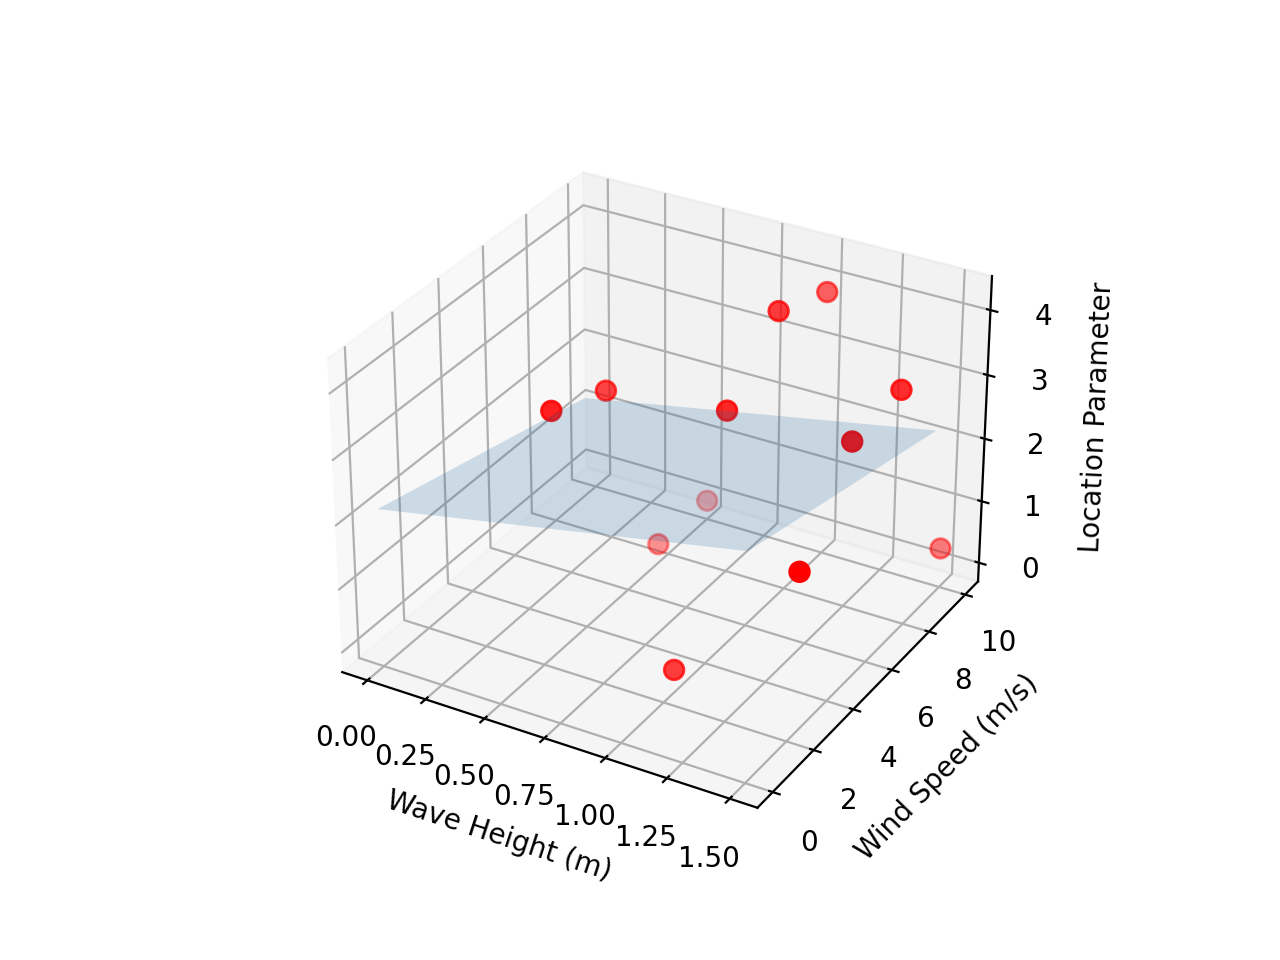

In [206]:
# plot points and fitted surface
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, alpha=0.2)
ax.scatter(location_data[:,1], location_data[:,2], location_data[:,0], c='r', s=50)
plt.xlabel('Wave Height (m)')
plt.ylabel('Wind Speed (m/s)')
ax.set_zlabel('Location Parameter')
ax.axis('auto')
ax.axis('tight')
plt.show()

# Modell 2 R(Hs,V)

In [237]:
def mu_func3D(hs, v):
    return C_loc[0]*hs +C_loc[1]*v +C_loc[2]
def sigma_func3D(hs, v):
    return C_scale[0]*hs +C_scale[1]*v +C_scale[2]
def sigma_func_2D_wind(v):
    return 0.39495517*v + 1.58860429

In [241]:
mu3D= mu_func3D(data.waveHeight, data.windSpeed)
sigma3D= sigma_func3D(data.waveHeight, data.windSpeed)
sigma2D= sigma_func_2D_wind(data.windSpeed)


print(type(sigma3D))
print(type(sigma2D))

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [247]:
con_dist_HsV= stats.genextreme(gev_fit_tower[0], mu3D, sigma2D)
print(con_dist_HsV)
rvs_3D= con_dist_HsV.rvs(size=800)
#print((rvs_3D))

In [244]:
peak_defl_tower= pd.DataFrame.to_numpy(data.peakDeflectionTower)
#print(peak_defl_tower)
model_error_3D= peak_defl_tower-rvs_3D
model_error_3D= abs(model_error)
model_error_3D_mean= model_error.mean()
print(model_error_3D_mean)

4.915074097211943


<ipython-input-245-b04f9e49732c>:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


<IPython.core.display.Javascript object>


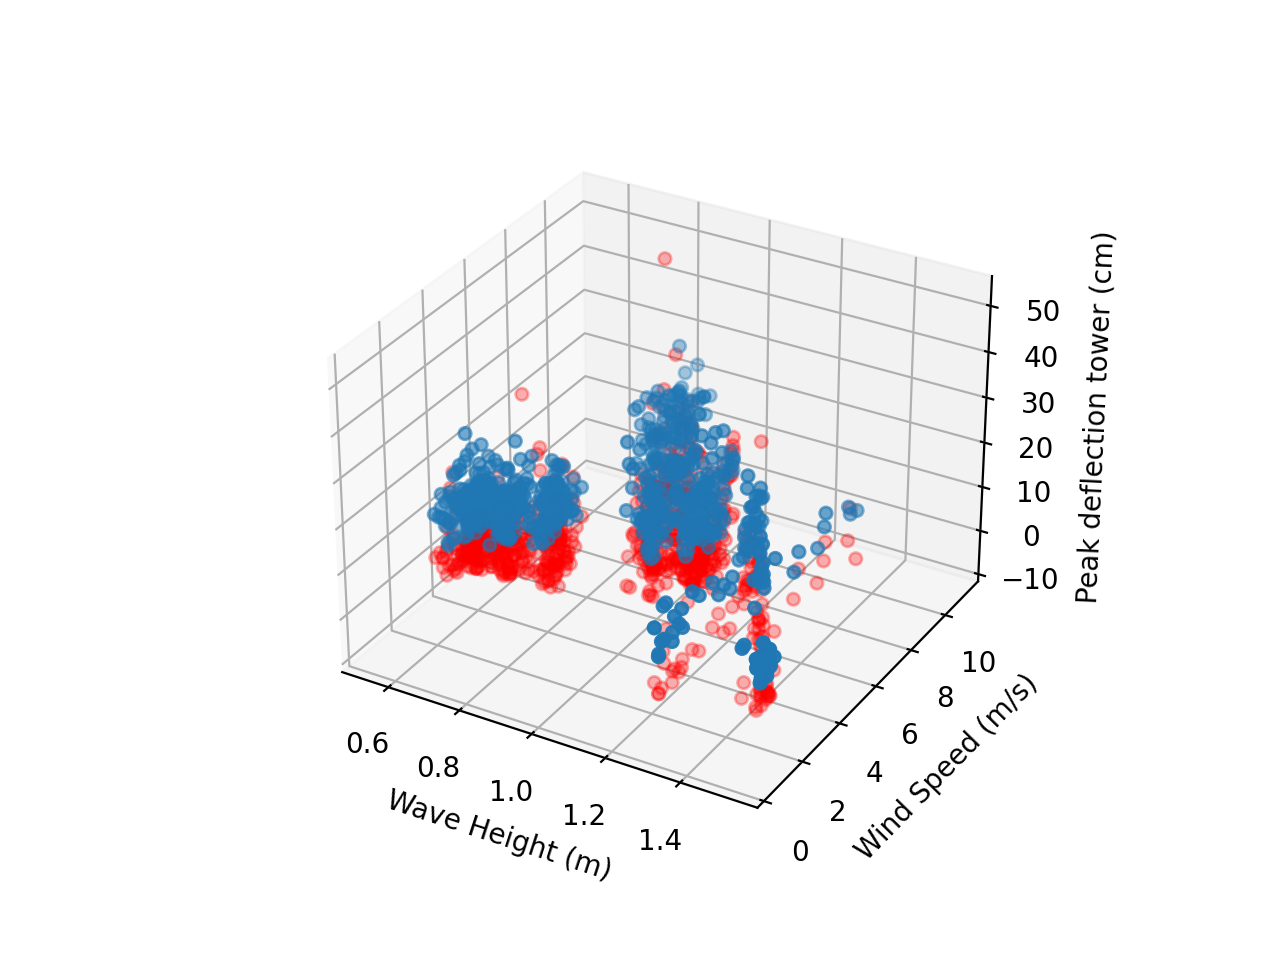

In [245]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(data.waveHeight, data.windSpeed, data.peakDeflectionTower, label='real data')
ax.scatter(data.waveHeight, data.windSpeed, rvs_3D, alpha=0.3, color= 'r', label='model data')
plt.xlabel('Wave Height (m)')
plt.ylabel('Wind Speed (m/s)')
ax.set_zlabel('Peak deflection tower (cm)')
ax.axis('auto')
ax.axis('tight')
plt.show()

## Goodness of fit

In [246]:
print(data.peakDeflectionTower.mean())
print(np.mean(rvs_3D))

print(data.peakDeflectionTower.median())
print(np.median(rvs_3D))

13.894361000000002
4.440924330662081
12.77685
3.3113124525834614


<IPython.core.display.Javascript object>


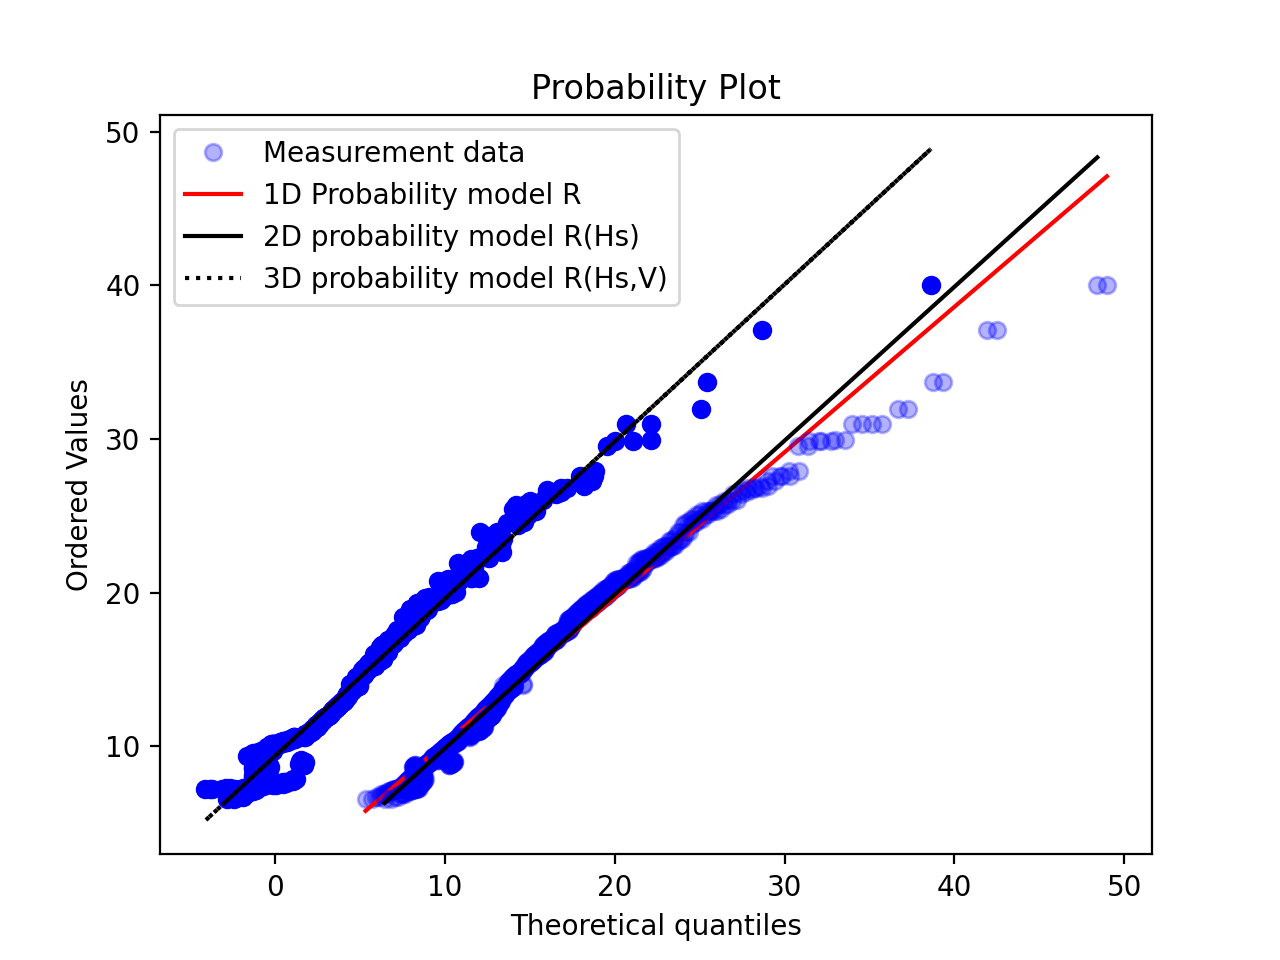

In [255]:
fig = plt.figure()
ax = fig.add_subplot(111)
stats.probplot(data.peakDeflectionTower, (gev_fit_tower[0], gev_fit_tower[1], gev_fit_tower[2]), dist='genextreme', plot=ax)
stats.probplot(data.peakDeflectionTower, (gev_fit_tower[0], mu2D, gev_fit_tower[2]), dist='genextreme', plot=ax)
stats.probplot(data.peakDeflectionTower, (gev_fit_tower[0], mu3D, sigma2D), dist='genextreme', plot=ax)
#ax.set_title("Probability plot of sample data against the quantiles of a specified theoretical distribution.")

ax.get_lines()[0].set_markerfacecolor('b')
ax.get_lines()[0].set_alpha(0.3)
ax.get_lines()[2].set_alpha(0.3)
ax.get_lines()[3].set_color('black')
ax.get_lines()[5].set_color('black')
ax.get_lines()[3].set_linestyle('-')
ax.get_lines()[5].set_linestyle(':')
ax.get_lines()[0].set_label('Measurement data')
ax.get_lines()[1].set_label('1D Probability model R')
ax.get_lines()[3].set_label('2D probability model R(Hs)')
ax.get_lines()[5].set_label('3D probability model R(Hs,V)')

ax.legend()
plt.show()